In [1]:
from slim_gsgp_lib_np.utils.utils import train_test_split
from slim_gsgp_lib_np.utils.callbacks import *
from slim_gsgp_lib_np.evaluators.fitness_functions import rmse
from slim_gsgp_lib_np.main_multi_slim import multi_slim 
from slim_gsgp_lib_np.main_slim import slim
from slim_gsgp_lib_np.datasets.data_loader import *
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import pdist, squareform
import numpy as np
import time
import os
from tqdm import tqdm
from itertools import combinations
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from slim_gsgp_lib_np.config.multi_slim_config import SlimParameters, GPParameters
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.representations.individual import Individual
from slim_gsgp_lib_np.algorithms.GSGP.representations.tree import Tree
from slim_gsgp_lib_np.algorithms.MULTI_SLIM.representations.tree import Tree as MultiTree
from slim_gsgp_lib_np.algorithms.GP.representations.tree import Tree as GP_Tree
from slim_gsgp_lib_np.utils.callbacks import SLIM_GSGP_Callback

# Import clear output function
from IPython.display import clear_output, display

from slim_gsgp_lib_np.main_gp import gp

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

In [3]:
X, y = datasets[0]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)
seed = 10

elite, gp_pop = gp(X_train=X_train, y_train=y_train, full_return=True, test_elite=False,
                       selector='dalex', n_iter=400, pop_size=100, 
                       max_depth=18, init_depth=4, p_xo=0.8, down_sampling=0.8, seed=seed, 
                       )

c:\Users\Mateus\Documents\Tese\Codigo\SLIM-TEST-LITE\slim_gsgp_lib_np\main_gp.py:178: UserWarning: No dataset name set. Using default value of dataset_1.
  warnings.warn("No dataset name set. Using default value of dataset_1.")


+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |       div       |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    dataset_1    |        0        |      68.461     |       None      |      0.006      |        5        |      6.180      |   21888795553   |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|    dataset_1    |        1        |      43.539     |       None      |      0.035      

In [66]:
seed = 10

X, y = datasets[0]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)

params = GPParameters(pop_size=100, n_iter=200, max_depth=7, init_depth=3,
                      selector='dalex', p_xo=0.6, down_sampling=1)

ensemble_tree, population, spec_pop = multi_slim(X_train=X_train, y_train=y_train, dataset_name='test',
                                gp_version='gp', params_gp=params, # population=spec_pop, 
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=1000, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=5, depth_condition=6, 
                                test_elite=False, timeout=200)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |       div       |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |     130.516     |       None      |      0.007      |        7        |      4.300      |     58375930    |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |     121.512     |       None      |      0.035      

In [67]:
# Simplify with default 10% threshold
simplified_tree = simplify_ensemble(ensemble_tree.collection, X_train, min_usage=0.1)
simplified_ensemble = MultiTree(simplified_tree)

# Evaluate performance
y_pred = simplified_ensemble.predict(X_train)
print(f"Original RMSE: {rmse(y_train, ensemble_tree.predict(X_train)):.4f}")
print(f"Simplified RMSE: {rmse(y_train, y_pred):.4f}")

# Evaluate performance
y_pred = simplified_ensemble.predict(X_test)
print(f"Original RMSE: {rmse(y_test, ensemble_tree.predict(X_test)):.4f}")
print(f"Simplified RMSE: {rmse(y_test, y_pred):.4f}")

rmse_results = calculate_specialist_rmse(
    ensemble_tree=simplified_ensemble,
    X_train=X_train,
    y_train=y_train,
)
masks = get_specialist_masks(simplified_ensemble.collection, X_train)

print(rmse_results)

Original RMSE: 31.3603
Simplified RMSE: 33.5214
Original RMSE: 75.1649
Simplified RMSE: 64.4837
{'S_0': (np.int64(193), np.float64(35.654303616456744)), 'S_88': (np.int64(105), np.float64(29.19727987685094))}


In [68]:
from collections import defaultdict
from itertools import chain

def get_specialist_masks(tree_node, X_data, current_mask=None):

    """
    Function used to get the masks for each specialist to be used for specialist tunning

    Write the rest of the documentation 

    """
    def recursion(tree_node, X_data, current_mask=None):
        if current_mask is None:
            current_mask = np.ones(X_data.shape[0], dtype=bool)
        
        if isinstance(tree_node, tuple):  # Condition node
            condition = tree_node[0]
            left_child = tree_node[1]
            right_child = tree_node[2]
            
            # Evaluate condition
            cond_results = condition.predict(X_data) > 0
            true_mask = current_mask & cond_results
            false_mask = current_mask & ~cond_results
            
            # Process both branches
            left_masks = recursion(left_child, X_data, true_mask)
            right_masks = recursion(right_child, X_data, false_mask)
            
            # Merge results while preserving all masks
            merged = defaultdict(list)
            for sp, masks in chain(left_masks.items(), right_masks.items()):
                merged[sp].extend(masks)
                
            return merged
            
        else:  # Specialist node (leaf)
            return {tree_node: [current_mask]}
    
    result = recursion(tree_node, X_data)
    merged = defaultdict(list)

    for ind, mask in result.items(): 
        merged[ind] = np.sum(mask, axis=0).astype(bool)

    return merged    

def calculate_specialist_rmse(ensemble_tree, X_train, y_train):
    """
    Calculates RMSE for each specialist on samples where their decision paths activate
    
    Parameters:
    ensemble_tree: The trained ensemble tree structure
    X_train (array-like): Training features
    y_train (array-like): True target values
    specialists (dict): Dictionary of specialist objects
    
    Returns:
    dict: Specialist IDs mapped to their path-specific RMSE scores
    """
    # Get all activation masks
    masks = get_specialist_masks(ensemble_tree.collection, X_train)
    specialists = ensemble_tree.SPECIALISTS
    
    # Calculate RMSE for each specialist
    rmse_scores = {}
    
    for sp_id, mask_list in masks.items():
        if sp_id not in specialists:
            continue
            
        # Combine all paths for this specialist
        combined_mask = mask_list
        n_samples = np.sum(combined_mask)
        
        if n_samples == 0:
            rmse_scores[sp_id] = (0, np.nan)
            continue
            
        # Get predictions for active samples
        X_active = X_train[combined_mask]
        y_true = y_train[combined_mask]
        y_pred = specialists[sp_id].predict(X_active)
        
        # Calculate RMSE
        error = y_true - y_pred
        rmse_value = np.sqrt(np.mean(error**2))
        rmse_scores[sp_id] = (n_samples, rmse_value)
    
    return rmse_scores


def simplify_ensemble(tree, X_data, min_usage=0.1):
    """
    Function to perform ensemble simplification 
    
    Parameters:
    tree: Ensemble tree collection
    X_data: Training features for usage analysis
    min_usage: Minimum usage threshold (0-1) for keeping nodes
    
    Returns:
    Simplified and cleaned ensemble structure
    """
    dataset_size = X_data.shape[0]
    usage_stats = defaultdict(dict)
    specialist_masks = defaultdict(list)
    
    # Step 1: Analyze both condition and specialist usage
    def analyze_usage(node, current_mask=None):
        """Tracks both condition and specialist usage"""
        if current_mask is None:
            current_mask = np.ones(X_data.shape[0], dtype=bool)
        
        # Base case: specialist node
        if not isinstance(node, tuple):
            # Track specialist usage
            usage_count = np.sum(current_mask)
            usage_stats[node] = {
                'usage_count': usage_count,
                'usage_ratio': usage_count / dataset_size,
                'is_specialist': True
            }
            specialist_masks[node].append(current_mask)
            return
        
        # Recursive case: condition node
        condition = node[0]
        cond_results = condition.predict(X_data) > 0
        true_mask = current_mask & cond_results
        false_mask = current_mask & ~cond_results
        
        # Track condition usage
        usage_count = np.sum(current_mask)
        true_count = np.sum(true_mask)
        false_count = np.sum(false_mask)
        
        usage_stats[condition] = {
            'usage_count': usage_count,
            'usage_ratio': usage_count / dataset_size,
            'true_ratio': true_count / usage_count if usage_count > 0 else 0,
            'false_ratio': false_count / usage_count if usage_count > 0 else 0,
            'is_specialist': False,
            'children': (node[1], node[2])
        }
        
        # Recursively analyze children
        analyze_usage(node[1], true_mask)
        analyze_usage(node[2], false_mask)
    
    # Step 2: Prune and clean the tree
    def prune_and_clean(node):
        """Integrated pruning and cleaning operations"""
        # Base case: specialist node
        if not isinstance(node, tuple):
            stats = usage_stats.get(node, {'usage_ratio': 0, 'is_specialist': True})
            return node if stats['usage_ratio'] >= min_usage else None
        
        # Condition node case
        condition = node[0]
        stats = usage_stats.get(condition, {'usage_ratio': 0, 'is_specialist': False})
        
        # Remove underused conditions
        if stats['usage_ratio'] < min_usage:
            # Choose majority branch
            majority_child = node[1] if stats.get('true_ratio', 0.5) >= 0.5 else node[2]
            return prune_and_clean(majority_child)
        
        # Process children
        left = prune_and_clean(node[1])
        right = prune_and_clean(node[2])
        
        # Handle pruned children
        if left is None and right is None:
            return None
        if left is None:
            return right
        if right is None:
            return left
            
        # Return cleaned structure
        return (condition, left, right)
    
    # Step 3: Execute analysis and pruning
    analyze_usage(tree)
    simplified = prune_and_clean(tree)
    
    # Step 4: Final structural cleanup
    def cleanup_structure(node):
        """Remove redundant condition structures"""
        if not isinstance(node, tuple):
            return node
            
        left = cleanup_structure(node[1])
        right = cleanup_structure(node[2])
        
        # Handle pruned children
        if left is None and right is None:
            return None
        if left is None:
            return right
        if right is None:
            return left
            
        # Check for redundant conditions
        if left == right:
            return left
            
        return (node[0], left, right)
    
    return cleanup_structure(simplified)

In [69]:
def replace_subtree(tree, path, new_subtree):
    """
    Replaces a subtree in a nested tuple using a specified path.
    Args:
        tree: The nested tuple representing the tree.
        path: A list of indices (e.g. [1, 2, 1]) leading to the parent tuple
              that should be replaced.
        new_subtree: The new subtree/value to insert at that position.
    Returns:
        A new tree with the specified replacement.
    """
    if not path:
        return new_subtree
    # Convert to a list to update and then back to tuple.
    index = path[0]
    lst = list(tree)
    lst[index] = replace_subtree(lst[index], path[1:], new_subtree)
    return tuple(lst)


def get_leaf_candidates(tree, path=None):
    """
    Recursively traverse the tree (nested tuple) and find candidate leaves
    for simplification. Candidates are the children (at index 1 or 2) in a tuple node
    which are terminal (not a tuple) and, as strings, do not end with '0'.
    
    Args:
         tree: A nested tuple.
         path: A list indicating the path to the current tree.
    Returns:
         A list of candidates. Each candidate is a tuple (parent_path, child_index, candidate_value).
    """
    if path is None:
        path = []
    
    candidates = []
    
    if isinstance(tree, tuple):
        # Expect a tuple of the form (function, left, right)
        # We assume tree[0] is a function/operator.
        op = tree[0]
        left = tree[1]
        right = tree[2]
        
        # Check left child: candidate if not a tuple and its string does not end with '0'
        if not isinstance(left, tuple) and (not str(left).endswith("0")):
            candidates.append((path, 1, left))
        
        # Check right child similarly.
        if not isinstance(right, tuple) and (not str(right).endswith("0")):
            candidates.append((path, 2, right))
        
        # Continue recursion on children that are subtrees.
        if isinstance(left, tuple):
            candidates.extend(get_leaf_candidates(left, path + [1]))
        if isinstance(right, tuple):
            candidates.extend(get_leaf_candidates(right, path + [2]))
    return candidates


def recursive_simplification(tree, threshold, X, y, max_iterations=10, verbose=False):
    """
    Repeatedly applies simplification moves to a tree.
    
    Steps:
      1. Extract tree.repr_.
      2. Calculate candidate simplification positions (last indices).
      3. Generate all possible simplified trees.
      4. Evaluate each and choose the candidate that improves RMSE the best, if improvement > threshold.
      5. Repeat if any change is made.
    
    Args:
         tree: An object with an attribute 'repr_' holding the tree as a nested tuple.
         threshold: The minimum RMSE improvement required to accept a change.
         max_iterations: Maximum number of passes to prevent infinite loops.
    Returns:
         A tuple (final_tree_repr, final_rmse).
    """
    # Start from the tree representation.
    preds = tree.predict(X)
    current_rmse = rmse(y, preds)
    current_repr = tree.repr_
    iteration = 0
    improved = True

    while improved and iteration < max_iterations:
        iteration += 1
        candidates = get_leaf_candidates(current_repr)
        
        best_candidate_repr = None
        best_candidate_rmse = current_rmse
        best_improvement = -100000
        
        # Generate and evaluate a new tree for every candidate move.
        for candidate in candidates:
            parent_path, child_index, candidate_value = candidate
            # Replace the tuple at parent's position with the candidate leaf.
            new_repr = replace_subtree(current_repr, parent_path, candidate_value)
            new_tree = GP_Tree(new_repr)
            new_preds = new_tree.predict(X)
            new_rmse = rmse(y, new_preds)

            # Calculate RMSE improvement.
            improvement_amt = (current_rmse - new_rmse)/current_rmse
            
            if improvement_amt > best_improvement:
                best_improvement = improvement_amt
                best_candidate_repr = new_repr
                best_candidate_rmse = new_rmse
        
        # If the best move yields enough improvement, update the tree representation.
        if best_improvement > threshold:
            print(f"Iteration {iteration}: improved RMSE from {current_rmse:.4f} to {best_candidate_rmse:.4f}") if verbose else None
            current_repr = best_candidate_repr
            current_rmse = best_candidate_rmse
        else:
            improved = False

    return current_repr, current_rmse

In [72]:
# Simplify with default 10% threshold
simplified_tree = simplify_ensemble(ensemble_tree.collection, X_train, min_usage=0.1)
simplified_ensemble = MultiTree(simplified_tree)

# Evaluate performance
y_pred = simplified_ensemble.predict(X_train)
print(f"Original RMSE: {rmse(y_train, ensemble_tree.predict(X_train)):.4f}")
print(f"Simplified RMSE: {rmse(y_train, y_pred):.4f}")

# Evaluate performance
y_pred = simplified_ensemble.predict(X_test)
print(f"Original RMSE: {rmse(y_test, ensemble_tree.predict(X_test)):.4f}")
print(f"Simplified RMSE: {rmse(y_test, y_pred):.4f}")

rmse_results = calculate_specialist_rmse(
    ensemble_tree=simplified_ensemble,
    X_train=X_train,
    y_train=y_train,
)
masks = get_specialist_masks(simplified_ensemble.collection, X_train)

print(rmse_results)

Original RMSE: 31.3603
Simplified RMSE: 33.5214
Original RMSE: 75.1649
Simplified RMSE: 64.4837
{'S_0': (np.int64(193), np.float64(35.654303616456744)), 'S_88': (np.int64(105), np.float64(29.19727987685094))}


In [73]:
rmse_threshold = -0.025

final_repr, final_rmse = recursive_simplification(simplified_ensemble.SPECIALISTS['S_0'], rmse_threshold, X_train[masks['S_0']], y_train[masks['S_0']], max_iterations=50, verbose=True)
    
print("\nFinal simplified tree representation:")
print(final_repr)
print("Final RMSE:", final_rmse)

# Create a new tree object with the final representation
final_tree = GP_Tree(final_repr)

Iteration 1: improved RMSE from 35.6543 to 35.6466
Iteration 2: improved RMSE from 35.6466 to 35.6543
Iteration 3: improved RMSE from 35.6543 to 35.6663
Iteration 4: improved RMSE from 35.6663 to 35.6818
Iteration 5: improved RMSE from 35.6818 to 35.8010

Final simplified tree representation:
('add', ('multiply', 'constant__0.09', ('divide', ('divide', 'x8', ('add', 'x18', 'x8')), ('divide', 'constant__0.68', ('add', 'x18', 'x8')))), ('add', 'x27', ('add', ('divide', ('multiply', 'x32', ('subtract', 'constant_0.35', 'x37')), ('add', 'x18', 'x8')), 'x8')))
Final RMSE: 35.80099056021699


In [82]:
# rerun GP 
params = GPParameters(pop_size=100, n_iter=2000, max_depth=8, init_depth=3, selector='dalex', p_xo=0.6, down_sampling=0.5)
# params = GPParameters(pop_size=100, n_iter=1000, max_depth=8, init_depth=3, selector='tournament', p_xo=0.8)

sp1_new, population = gp(X_train=X_train[masks['S_0']], y_train=y_train[masks['S_0']], dataset_name='test', verbose=1,
                                test_elite=False, full_return=True, seed=seed, **params.__dict__, elite_tree=sp1_new,
                                )

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |       div       |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      32.619     |       None      |      0.004      |        51       |      4.780      |     77783276    |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |      32.603     |       None      |      0.035      

In [43]:
copy_simplified = MultiTree(simplified_ensemble.collection) 
copy_simplified.SPECIALISTS['S_52'] = sp1_new 

print(rmse(copy_simplified.predict(X_train), y_train))
print(rmse(simplified_ensemble.predict(X_train), y_train))

calculate_specialist_rmse(
    ensemble_tree=copy_simplified,
    X_train=X_train,
    y_train=y_train,
)

23.966702445801243
23.966702445801243


{'S_52': (np.int64(107), np.float64(19.275327745567242)),
 'S_21': (np.int64(191), np.float64(26.23069705612855))}

### Synthetic datasets

In [149]:
def dataset1(n=500, seed=0, noise=0):
    """
    Synthetic dataset with no pieces
    """
    def f1(x): 
        return 4*x[0]**4 - 3*x[0]**3 - 5*x[0]**2 + 4*x[0] + 3
    
    np.random.seed(seed)
    x = np.random.uniform(-3, 3, size=(n, 3))
    y_clean = f1(x.T)
    std_dev = np.std(y_clean)
    y_noisy = y_clean + np.random.normal(0, (noise/100) * std_dev, size=n)
    return x, y_noisy

def dataset2(n=500, seed=0, noise=0):
    """
    Synthetic dataset with a single threshold-based piecewise function and a slight class imbalance
    The functions are simple
    """
    def f2(x):
        """
        Simple threshold condition and a simple function
        """
        if x[0] < 0.8:
            return 2 * x[0] + 1
        else:
            return -3 * x[0] + 5
        
    np.random.seed(seed)
    x = np.random.uniform(-3, 3, size=(n, 3))
    print('Class 1 has', np.sum(x[:, 0] < 0.8), 'samples, and class 2 has', np.sum(x[:, 0] >= 0.8), 'samples') 
    y_clean = np.array([f2(xi) for xi in x])
    std_dev = np.std(y_clean)
    y_noisy = y_clean + np.random.normal(0, (noise / 100) * std_dev, size=n)
    return x, y_noisy
    
def dataset3(n=500, seed=0, noise=0):
    """
    Synthetic dataset with a threshold-based piecewise function and a slight class imbalance
    The functions are harder
    """
    def f3(x): 
        """
        Simple theshold condition and a hard function to approximate
        """
        if x[0] < -1: 
            return x[0]**2 
        else: 
            return x[0]**4 - 3*x[0]**3 + 2*x[0]**2 - 4
    
    np.random.seed(seed)
    x = np.random.uniform(-3, 3, size=(n, 3))
    print('Class 1 has', np.sum(x[:, 0] < -1), 'samples, and class 2 has', np.sum(x[:, 0] >= -1), 'samples')
    y_clean = np.array([f3(xi) for xi in x])
    std_dev = np.std(y_clean)
    y_noisy = y_clean + np.random.normal(0, (noise / 100) * std_dev, size=n)
    return x, y_noisy

In [150]:
dataset3(noise=0)

Class 1 has 182 samples, and class 2 has 318 samples


(array([[ 0.29288102,  1.2911362 ,  0.61658026],
        [ 0.2692991 , -0.4580712 ,  0.87536468],
        [-0.37447673,  2.350638  ,  2.78197656],
        ...,
        [ 0.9471728 , -0.84328109,  2.40220471],
        [ 2.89964919, -2.81744091, -1.83826026],
        [-2.32650004, -2.74581572, -1.63355404]]),
 array([-3.89645271, -3.90828688, -3.54232732, -1.75646595, -3.84300531,
         6.13663975, -4.61684387, -4.52517348,  5.2457189 ,  3.93160082,
         1.99562615, -3.84206248, -3.80339095, -4.0983686 , -4.21269984,
        -4.0243811 ,  1.22640097, -3.56017349,  3.05109875,  2.1911412 ,
         4.18686282,  4.71281676, -4.25430578,  5.87291386,  9.1018843 ,
         7.64452407,  1.49611749, -2.99231634, -3.84656287,  5.93583512,
         1.1850201 , -4.35240925, -3.80810136,  8.83175657, -4.48213042,
        -3.82503456,  2.76061616, -3.63450195, -4.36680422, -3.81574162,
        -4.41638823, -3.88462922,  8.3223065 ,  1.5864268 ,  4.78364968,
        -3.80332559, -3.92086383, 

In [ ]:
# X, y = datasets[1]()
# X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)
# X_train = MinMaxScaler().fit_transform(X_train)
# X_test = MinMaxScaler().fit_transform(X_test)
# y_train = MinMaxScaler().fit_transform(y_train.reshape(-1, 1)).ravel()
# y_test = MinMaxScaler().fit_transform(y_test.reshape(-1, 1)).ravel()

# seed = 2

# slim_params = SlimParameters(pop_size=100, n_iter=500, max_depth=14, init_depth=6, p_inflate=0.3, p_struct=0.2, eps_fraction=1e-6, 
#                              prob_const=0.2, n_elites=1, selector='lexicase', decay_rate=0.2, p_xo=0, p_struct_xo=0, 
#                              prob_terminal=0.7, mode='exp')

# ensemble_tree, population = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
#                                 slim_parameters=slim_params, slim_version='SLIM*ABS',
#                                 full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=500, p_mut=0.8, test_elite=True, timeout=200,
# )

TRAIN: 200 50
TEST: 113 27


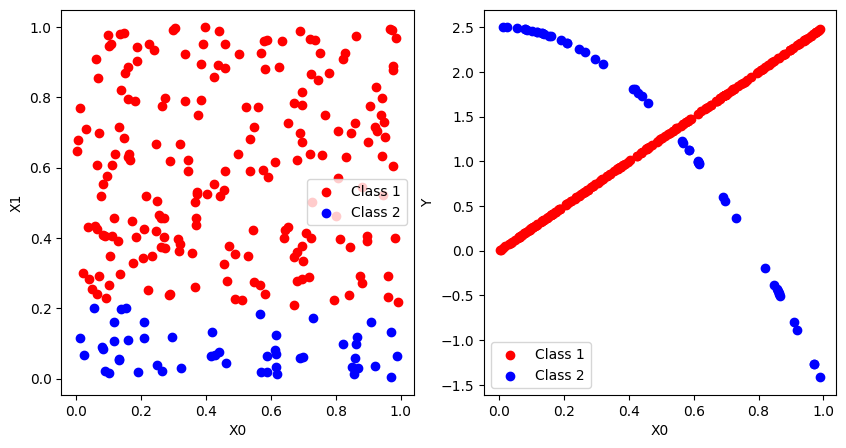

In [31]:
# Create a modal dataset
np.random.seed(0)
X_train = np.random.rand(250, 3)
X_test = np.random.rand(140, 3)
count1, count2 = 0, 0

threshold = 0.2

def f(x):
    global count1, count2
    if x[1] > threshold:
        count1 += 1
        value = 2.5 * x
        return value[0]
    else:
        count2 += 1
        value = -4 * (x ** 2) + 2.5
        # value = -2.5 * x
        return value[0]
    
y_train = np.array([f(x) for x in X_train])
print('TRAIN:', count1, count2)
count1, count2 = 0, 0

y_test = np.array([f(x) for x in X_test])
print('TEST:', count1, count2)

X_train_1 = np.where(X_train[:, 1] > threshold)[0]  
X_train_2 = np.where(X_train[:, 1] <= threshold)[0]
y_train_1 = y_train[X_train_1]
y_train_2 = y_train[X_train_2]
X_train_1 = X_train[X_train_1]
X_train_2 = X_train[X_train_2]

# Scatterplot 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(X_train_1[:, 0], X_train_1[:, 1], c='r', label='Class 1')
axs[0].scatter(X_train_2[:, 0], X_train_2[:, 1], c='b', label='Class 2')
axs[0].set_xlabel('X0')
axs[0].set_ylabel('X1')
axs[0].legend()

axs[1].scatter(X_train_1[:, 0], y_train_1, c='r', label='Class 1')
axs[1].scatter(X_train_2[:, 0], y_train_2, c='b', label='Class 2')
axs[1].set_xlabel('X0')
axs[1].set_ylabel('Y')
axs[1].legend()
plt.show()

TRAIN: 240 10
TEST: 137 3


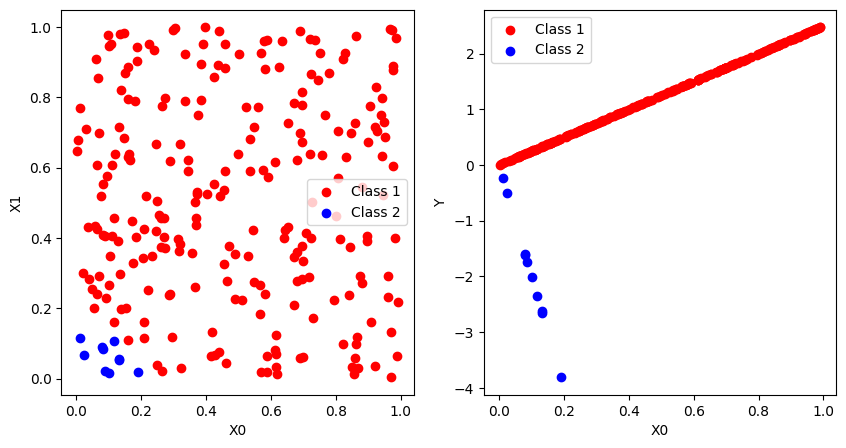

In [104]:
# Create a modal dataset
np.random.seed(0)
X_train = np.random.rand(250, 3)
X_test = np.random.rand(140, 3)
count1, count2 = 0, 0

threshold = 0.25

def f(x):
    global count1, count2
    if x[0] + x[1] > threshold:
        count1 += 1
        value = 2.5 * x
        return value[0]
    else:
        count2 += 1
        # value = -4 * (x ** 2) + 2.5
        value = -20 * x
        return value[0]
    
y_train = np.array([f(x) for x in X_train])
print('TRAIN:', count1, count2)
count1, count2 = 0, 0

y_test = np.array([f(x) for x in X_test])
print('TEST:', count1, count2)

X_train_1 = np.where(X_train[:, 0] + X_train[:, 1] > threshold)[0]
X_train_2 = np.where(X_train[:, 0] + X_train[:, 1] <= threshold)[0]
y_train_1 = y_train[X_train_1]
y_train_2 = y_train[X_train_2]
X_train_1 = X_train[X_train_1]
X_train_2 = X_train[X_train_2]

# Scatterplot 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(X_train_1[:, 0], X_train_1[:, 1], c='r', label='Class 1')
axs[0].scatter(X_train_2[:, 0], X_train_2[:, 1], c='b', label='Class 2')
axs[0].set_xlabel('X0')
axs[0].set_ylabel('X1')
axs[0].legend()

axs[1].scatter(X_train_1[:, 0], y_train_1, c='r', label='Class 1')
axs[1].scatter(X_train_2[:, 0], y_train_2, c='b', label='Class 2')
axs[1].set_xlabel('X0')
axs[1].set_ylabel('Y')
axs[1].legend()
plt.show()

In [ ]:
class LogSpecialist(SLIM_GSGP_Callback):
    def __init__(self):
        self.log = []
        self.count_specialists = []

    def on_generation_start(self, optimizer, generation):            
        min_1, min_2 = 1e10, 1e10
        best_1, best_2 = None, None
        count_1, count_2 = 0, 0
        for ind in optimizer.population:
            if hasattr(optimizer, 'slim_version'): 
                ind.version = optimizer.slim_version
            preds_1 = ind.predict(X_train_1)
            preds_2 = ind.predict(X_train_2)
            error_1 = rmse(preds_1, y_train_1)
            error_2 = rmse(preds_2, y_train_2)
            if error_1 < error_2: 
                count_1 += 1
            else:
                count_2 += 1

            if error_1 < min_1:
                min_1 = error_1
                best_1 = ind
            if error_2 < min_2:
                min_2 = error_2
                best_2 = ind
            
        y_1 = best_1.predict(X_train_1)
        y_2 = best_2.predict(X_train_2)

        self.count_specialists.append([count_1, count_2])
        self.log.append([rmse(y_1, y_train_1), rmse(y_2, y_train_2)])

    # def on_train_end(self, slim_gsgp):
    #     self.plot_specialist_fitnesses()

    def plot_specialist_fitnesses(self):
        fig, ax = plt.subplots()
        ax.plot(self.log)
        ax.set_xlabel('Generation')
        ax.set_ylabel('RMSE')
        ax.legend(['Specialist 1', 'Specialist 2'])
        plt.show()

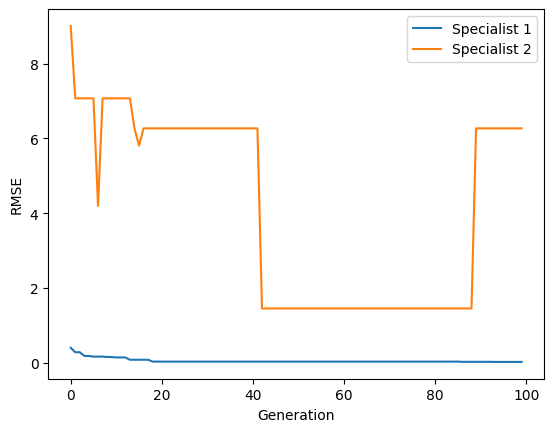

g1            g2        min_g1        min_g2  min_g1_point  \
0   1.104658e-16  1.846037e+00  1.104658e-16  1.846037e+00            43   
1   1.104658e-16  8.560233e+00  1.104658e-16  5.340468e+00            16   
2   3.777586e-03  8.308591e+00  3.777586e-03  2.385845e+00            98   
3   8.957614e-03  1.169296e+00  8.957614e-03  1.113175e+00            30   
4   3.466996e-02  2.971751e-01  3.466996e-02  2.502267e-02            62   
5   1.636799e-02  4.971066e+00  1.636799e-02  2.215075e+00            94   
6   2.355139e-17  8.574341e+00  2.355139e-17  3.692967e+00            36   
7   9.003124e-03  8.475017e+00  9.003124e-03  6.444522e+00            69   
8   3.228027e-03  2.417190e-15  3.228027e-03  2.417190e-15            39   
9   4.159926e-03  2.193224e+00  4.159926e-03  5.554792e-01            93   
10  1.113024e-02  1.445012e+00  1.113024e-02  1.445012e+00             5   
11  1.104658e-16  6.946817e-01  1.104658e-16  6.946817e-01            33   
12  3.339071e-03  6.405805e-01  3.339071e-03  1.191616e-15            92   
13  3.040471e-17  5.266366e+00  3.040471e-17  2.078226e+00            16   
14  0.000000e+00  1.017487e+00  0.000000e+00  3.133177e-01            43   
15  4.598578e-02  7.332676e+00  4.598578e-02  3.997989e+00            93   
16  0.000000e+00  4.227048e-01  0.000000e+00  4.227048e-01             3   
17  1.104658e-16  2.548844e+00  1.104658e-16  1.928017e+00            13   
18  0.000000e+00  1.597362e+00  0.000000e+00  1.597362e+00             8   
19  1.959549e-02  6.268877e+00  1.959549e-02  1.450213e+00            93   

    min_g2_point  mean_count_1  
0             95         92.15  
1             14         96.90  
2             29         91.46  
3             98         94.65  
4             90         94.44  
5             84         87.71  
6             25         94.11  
7             19         93.19  
8             98         85.26  
9             26         89.39  
10            98         95.03  
11            93         93.67  
12            13         85.10  
13            98         92.72  
14            71         85.25  
15            73         93.18  
16            92         85.38  
17            95         94.87  
18            30         87.95  
19            42         93.45

100%|██████████| 20/20 [06:17<00:00, 18.87s/it]


In [106]:
data = None

for seed in tqdm(range(20)):
    temp_data = {}
    log_specialist = LogSpecialist()    
    
    params = GPParameters(pop_size=100, n_iter=100, max_depth=6, init_depth=3, selector='e_lexicase', p_xo=0.8, n_cases=10, 
                        callbacks=[log_specialist], particularity_pressure=20)

    ensemble_tree, population = gp(X_train=X_train, y_train=y_train, dataset_name='test', verbose=0,
                                test_elite=False, full_return=True, seed=seed, **params.__dict__)

    g1, g2 = log_specialist.log[-1]
    log = np.array(log_specialist.log)
    min_g1 = np.min(log[:, 0])
    min_g2 = np.min(log[:, 1])
    min_g1_point = np.where(log[:, 0] == min_g1)[0][0]
    min_g2_point = np.where(log[:, 1] == min_g2)[0][0]
    mean_count_1 = np.mean([i[0] for i in log_specialist.count_specialists])

    temp_data[seed] = [g1, g2, min_g1, min_g2, min_g1_point, min_g2_point, mean_count_1]
    temp_data = pd.DataFrame.from_dict(temp_data, orient='index', columns=['g1', 'g2', 'min_g1', 'min_g2', 'min_g1_point', 'min_g2_point', 'mean_count_1'])
    data = pd.concat([data, temp_data]) if data is not None else temp_data

    # Clear jupyter output
    clear_output()
    log_specialist.plot_specialist_fitnesses() 
    display(data)

In [17]:
seed = 0
log_specialist = LogSpecialist()    

params = GPParameters(pop_size=100, n_iter=200, max_depth=6, init_depth=3, selector='e_lexicase', p_xo=0, n_cases=250, 
                    callbacks=[log_specialist], particularity_pressure=20)

ensemble_tree, population = gp(X_train=X_train, y_train=y_train, dataset_name='test', verbose=1,
                            test_elite=False, full_return=True, seed=seed, **params.__dict__)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |       div       |       mut       |        xo       |      lex_r      |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      1.015      |       None      |      0.012      |        3        |      4.200      |        5        |     N/A (0)     |     N/A (0)     |      0.000      |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|


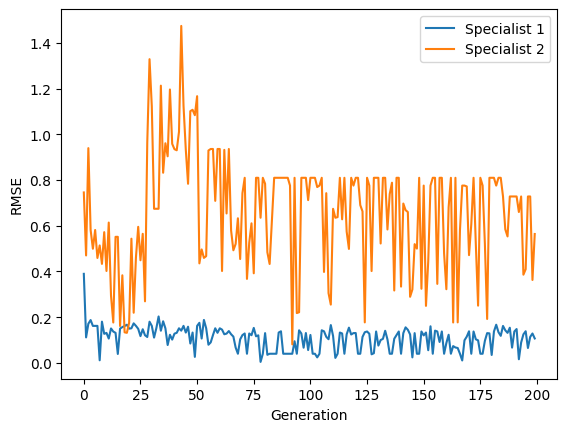

In [18]:
log_specialist.plot_specialist_fitnesses()

In [63]:
seed = 10

log_specialist = LogSpecialist()    

# params = SlimParameters(pop_size=100, n_iter=100, max_depth=10, init_depth=4, p_inflate=0.3, p_struct=0.3, n_cases=5,
#                              prob_const=0.2, n_elites=1, selector='dalex', decay_rate=0.2, p_xo=0, p_struct_xo=0, 
#                              prob_terminal=0.7, mode='exp', elitism=True, callbacks=[log_specialist])

# params = GPParameters(pop_size=100, n_iter=200, max_depth=6, init_depth=3, selector='manual_e_lexicase', p_xo=0.8, n_cases=20, 
#                       callbacks=[log_specialist], epsilon=1e-3)

params = GPParameters(pop_size=100, n_iter=200, max_depth=5, init_depth=3, selector='dalex', p_xo=0.6, n_cases=10, 
                      callbacks=[log_specialist])
                      

ensemble_tree, population, slim_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                params_gp=params, gp_version='gp', # population=slim_pop,
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=500, p_mut=0.8, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=5, 
                                test_elite=True, timeout=200, n_elites=1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |       div       |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.853      |      0.852      |      0.011      |        3        |      4.320      |        2        |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |      0.806      |      0.829      |      0.024      

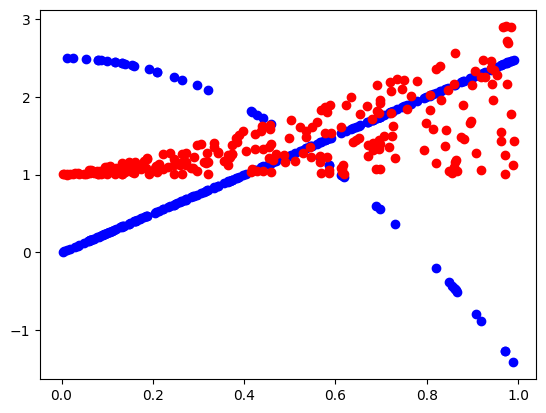

In [68]:
preds_1 = slim_pop[0].predict(X_train)
plt.scatter(X_train[:, 0], y_train, c='b')
plt.scatter(X_train[:, 0], preds_1, c='r')
plt.show()

RMSE Specialist 1: 0.005565117897071625
RMSE Specialist 2: 1.3097966586336212


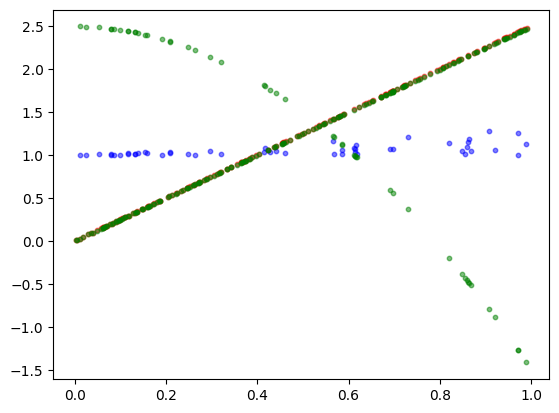

In [110]:
filter_true = np.where(ensemble_tree.collection[0].predict(X_train) > 0)[0]
filter_false = np.where(ensemble_tree.collection[0].predict(X_train) <= 0)[0]

# Use the filter for the scatterplot
specialists = ensemble_tree.SPECIALISTS 
sp1 = specialists[ensemble_tree.collection[1]]
sp2 = specialists[ensemble_tree.collection[2]]

X_train_true = X_train[filter_true]
X_train_false = X_train[filter_false]

y_train_true = sp1.predict(X_train_true)
y_train_false = sp2.predict(X_train_false)

# Print the RMSE of the specialists
print('RMSE Specialist 1:', rmse(y_train_true, y_train[filter_true]))
print('RMSE Specialist 2:', rmse(y_train_false, y_train[filter_false]))

plt.scatter(X_train_true[:, 0], y_train_true, c='r', s=10, alpha=0.5)
plt.scatter(X_train_false[:, 0], y_train_false, c='b', s=10, alpha=0.5)
plt.scatter(X_train[:, 0], y_train, c='g', s=10, alpha=0.5)
plt.show()

In [ ]:
y_train_false = y_train[filter_false]

# rerun GP 
params = GPParameters(pop_size=100, n_iter=1000, max_depth=6, init_depth=3, selector='tournament', p_xo=0.8)

sp2_new, population = gp(X_train=X_train_false, y_train=y_train_false, dataset_name='test', verbose=1,
                                test_elite=False, full_return=True, seed=seed, **params.__dict__)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |       div       |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      1.111      |       None      |      0.008      |        7        |      4.320      |        3        |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
|       test      |        1        |      1.111      |       None      |      0.009      

RMSE Specialist 1: 0.005565117897071625
RMSE Specialist 2 new: 0.07489431589379918


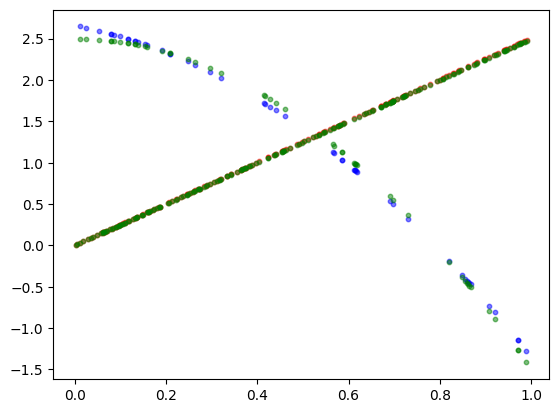

In [118]:
y_train_true = sp1.predict(X_train_true)
y_train_false = sp2_new.predict(X_train_false)

# Print the RMSE of the specialists
print('RMSE Specialist 1:', rmse(y_train_true, y_train[filter_true]))
print('RMSE Specialist 2 new:', rmse(y_train_false, y_train[filter_false]))

plt.scatter(X_train_true[:, 0], y_train_true, c='r', s=10, alpha=0.5)
plt.scatter(X_train_false[:, 0], y_train_false, c='b', s=10, alpha=0.5)
plt.scatter(X_train[:, 0], y_train, c='g', s=10, alpha=0.5)
plt.show()

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |    avg_nodes    |       div       |       mut       |        xo       |      lex_r      |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.907      |      0.893      |      0.005      |        3        |      4.320      |        2        |     N/A (0)     |     N/A (0)     |      0.000      |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|


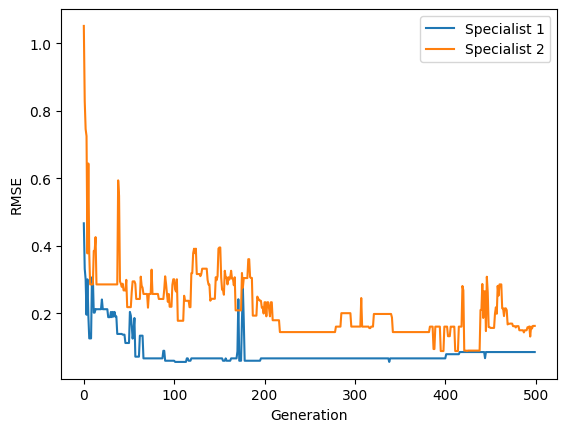

In [54]:
seed = 10

log_specialist = LogSpecialist()    

# params = SlimParameters(pop_size=100, n_iter=1000, max_depth=10, init_depth=4, p_inflate=0.2, p_struct=0.4, n_cases=10,
#                              prob_const=0.2, n_elites=1, selector='e_lexicase', decay_rate=0.2, p_xo=0, p_struct_xo=0, 
#                              prob_terminal=0.7, mode='exp', elitism=True, callbacks=[log_specialist])

params = GPParameters(pop_size=100, n_iter=500, max_depth=9, init_depth=3, selector='e_lexicase', p_xo=0.8, n_cases=5, callbacks=[log_specialist])
                      

ensemble_tree, population, slim_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                params_gp=params, gp_version='gp',
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=250, p_mut=0.7, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=7, 
                                test_elite=True, timeout=200, n_elites=1)

log_specialist.plot_specialist_fitnesses()  

In [36]:
min_1, min_2 = 1e10, 1e10
best_1, best_2 = None, None
best_ind_1, best_ind_2 = None, None

for i, ind in enumerate(slim_pop):
    preds_1 = ind.predict(X_train_1)
    preds_2 = ind.predict(X_train_2)
    error_1 = rmse(preds_1, y_train_1)
    error_2 = rmse(preds_2, y_train_2)
    if error_1 < min_1:
        min_1 = error_1
        best_1 = ind 
        best_ind_1 = i
    if error_2 < min_2:
        min_2 = error_2
        best_2 = ind
        best_ind_2 = i

y_1 = best_1.predict(X_train_1)
y_2 = best_2.predict(X_train_2)

print(f'TRAIN 1 {best_ind_1}:', rmse(y_1, y_train_1))
print(f'TRAIN 2: {best_ind_2}', rmse(y_2, y_train_2))

TRAIN 1 23: 0.23912573931729764
TRAIN 2: 14 0.6251042181821997


In [21]:
params = GPParameters(pop_size=100, n_iter=500, max_depth=8, init_depth=4, eps_fraction=1e-6,
                      selector='lexicase', p_xo=0)

rmses = []

for seed in range(50):
    ensemble_tree, population, slim_pop = multi_slim(X_train=X_train, y_train=y_train, dataset_name='test',
                                gp_version='gp', params_gp=params, population=gp_population,
                                full_return=True, seed=seed, verbose=0, pop_size=100, n_iter=1000, p_mut=0.6, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=3, depth_condition=3, 
                                test_elite=False, timeout=200)
    
    preds = ensemble_tree.predict(X_test)
    error = rmse(preds, y_test)
    rmses.append(error)

In [ ]:
seed = 10

params = GPParameters(pop_size=100, n_iter=500, max_depth=8, init_depth=4, eps_fraction=1e-6,
                      selector='lexicase', p_xo=0)

ensemble_tree, population, slim_pop = multi_slim(X_train=X_train, y_train=y_train, dataset_name='test',
                                gp_version='gp', params_gp=params, population=gp_population,
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=1000, p_mut=0.6, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=3, depth_condition=3, 
                                test_elite=False, timeout=200)

In [11]:
ensemble_tree.print_tree_representation()

if (
  add(
    add(
      x1
      constant__0.21
    )
    add(
      x0
      constant__0.78
    )
  )
) > 0 then
  S_60
else
  S_94
endif



In [ ]:
seed = 10

ensemble_tree, population, slim_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                slim_version='SLIM*ABS', population=gp_population,
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=2000, p_mut=0.6, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=3, 
                                test_elite=True, timeout=200)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |   total_nodes   |  average_depth  |       div       |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.630      |      0.691      |      0.001      |        1        |        43       |      1.310      |        1        |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|


In [8]:
ensemble_tree.print_tree_representation()

if (
  subtract(
    divide(
      x0
      x0
    )
    add(
      x1
      x0
    )
  )
) > 0 then
  S_67
else
  S_65
endif



### In-depth look into lexicase selection splitting

TRAIN: 81 69
TEST: 7 3


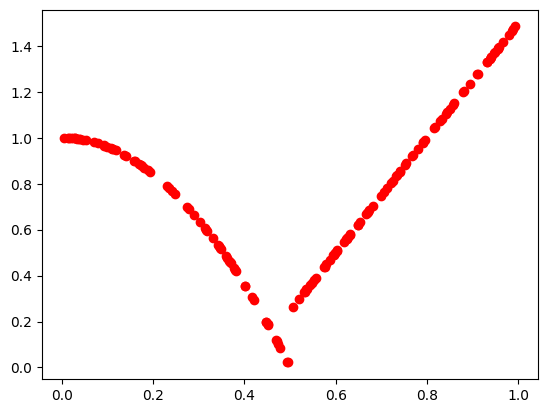

In [147]:
# Create a modal dataset
# Set random seed
np.random.seed(11)

X_train = np.random.rand(150, 3)

# Order X_train by the first column 
X_train = X_train[np.argsort(X_train[:, 0])]

X_test = np.random.rand(10, 3)
count1, count2 = 0, 0

def f(x):
    global count1, count2
    if x[0] > 0.5: 
        count1 += 1
        value = 2.5 * x - 1
        return value[0]
    else:
        count2 += 1
        value = -4 * (x ** 2) + 1
        # value = -4 * x + 2
        return value[0]
    
y_train = np.array([f(x) for x in X_train])
print('TRAIN:', count1, count2)
count1, count2 = 0, 0

y_test = np.array([f(x) for x in X_test])
print('TEST:', count1, count2)

X_train_1 = np.where(X_train[:, 0] > 0.5 )[0]
X_train_2 = np.where(X_train[:, 0] <= 0.5)[0]
y_train_1 = y_train[X_train_1]
y_train_2 = y_train[X_train_2]
X_train_1 = X_train[X_train_1]
X_train_2 = X_train[X_train_2]

# Plot the scatter plot
plt.scatter(X_train[:, 0], y_train, c='r')
plt.show()

In [148]:
class LogSpecialist(SLIM_GSGP_Callback):
    def __init__(self):
        self.log = []
        self.positions = []
        self.population_log = []
        self.best_log = []

    def on_generation_start(self, optimizer, generation): 
        self.population_log.append(optimizer.population)      
        # Get the order of the population fitness 
        fitness_positions = np.argsort(optimizer.population.fit)
        min_1, min_2 = 1e10, 1e10
        best_1, best_2 = None, None
        fit_pos_1, fit_pos_2 = None, None
        for i, ind in enumerate(optimizer.population.population):
            if hasattr(optimizer, 'slim_version'): 
                ind.version = optimizer.slim_version
            preds_1 = ind.predict(X_train_1)
            preds_2 = ind.predict(X_train_2)
            error_1 = rmse(preds_1, y_train_1)
            error_2 = rmse(preds_2, y_train_2)
            if error_1 < min_1:
                min_1 = error_1
                best_1 = ind
                fit_pos_1 = fitness_positions[i]
            if error_2 < min_2:
                min_2 = error_2
                best_2 = ind
                fit_pos_2 = fitness_positions[i]
            
        y_1 = best_1.predict(X_train_1)
        y_2 = best_2.predict(X_train_2)

        self.log.append([rmse(y_1, y_train_1), rmse(y_2, y_train_2)])
        self.positions.append([fit_pos_1, fit_pos_2])
        self.best_log.append([best_1, best_2])

    def on_train_end(self, slim_gsgp):
        self.plot_specialist_fitnesses()

    def plot_specialist_fitnesses(self):
        fig, ax = plt.subplots()
        ax.plot(self.log)
        ax.set_xlabel('Generation')
        ax.set_ylabel('RMSE')
        ax.legend(['Specialist 1', 'Specialist 2'])
        plt.show()

In [155]:
seed = 0
n_cases = 5
pop_size = 400

log_specialist = LogSpecialist()    

# params = SlimParameters(pop_size=100, n_iter=100, max_depth=10, init_depth=4, p_inflate=0.3, p_struct=0.3, n_cases=5,
#                              prob_const=0.2, n_elites=1, selector='dalex', decay_rate=0.2, p_xo=0, p_struct_xo=0, 
#                              prob_terminal=0.7, mode='exp', elitism=True, callbacks=[log_specialist])

params = GPParameters(pop_size=pop_size, n_iter=50, max_depth=8, init_depth=3, selector='dalex', 
                      p_xo=0.8, n_cases=n_cases, callbacks=[log_specialist])
                      

ensemble_tree, population, slim_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                params_gp=params, gp_version='gp', population=slim_pop,
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=1000, p_mut=0.6, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=7, 
                                test_elite=True, timeout=200, n_elites=1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |   total_nodes   |  average_depth  |       div       |       mut       |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.226      |      0.132      |      0.010      |        1        |        85       |      1.330      |       187       |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|


In [158]:
ensemble_tree.print_tree_representation()

if (
  add(
    add(
      constant__0.03
      constant__0.33
    )
    add(
      subtract(
        add(
          x2
          constant__0.17
        )
        x2
      )
      x0
    )
  )
) > 0 then
  S_143
else
  S_334
endif



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

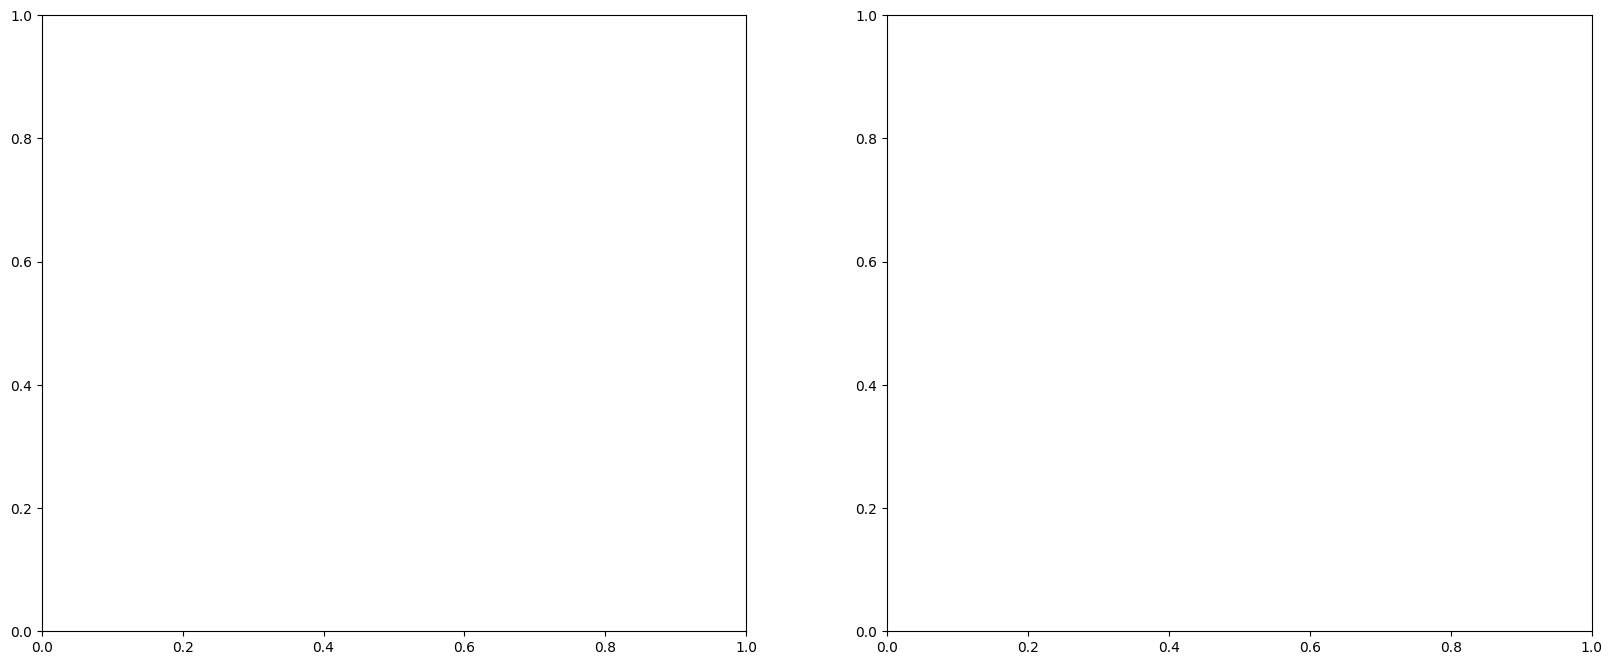

In [159]:
# Plot the population log in two separate plots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(np.array(log_specialist.log)[:,0])
ax[0].set_xlabel('Generation')
ax[0].set_ylabel('RMSE')
ax[0].legend(['Specialist 1'])
# Also plot the position on a twin axis
ax2 = ax[0].twinx()
ax2.plot(np.array(log_specialist.positions)[:,0], 'r')
ax2.set_ylabel('Position in population', color='r')

ax[1].plot(np.array(log_specialist.log)[:,1])
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('RMSE')
ax[1].legend(['Specialist 2'])
# Also plot the position on a twin axis
ax2 = ax[1].twinx()
ax2.plot(np.array(log_specialist.positions)[:,1], 'r')
ax2.set_ylabel('Position in population', color='r')
plt.show()

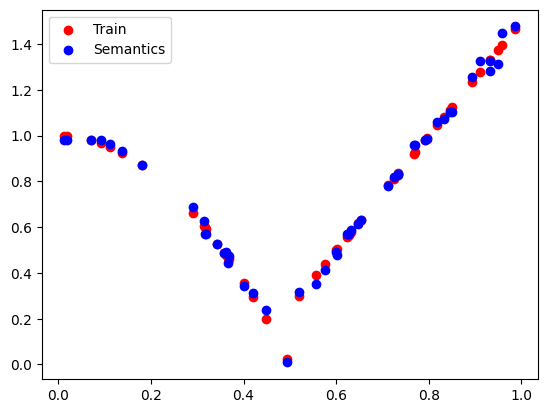

In [140]:
i = 5
pop = log_specialist.population_log[i]
errors = np.abs(pop.errors_case)
selected_best = np.argmin(errors, axis=0)
semantics = pop.train_semantics

sem_agg = []
for i, ind in enumerate(selected_best): 
    sem_agg.append(semantics[ind][i])

# Plot the semantics 
plt.scatter(X_train[:, 0], y_train, c='r', label='Train')
plt.scatter(X_train[:, 0], sem_agg, c='b', label='Semantics')
plt.legend()
plt.show()

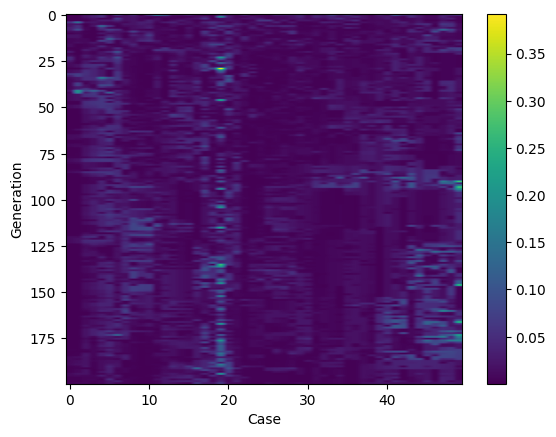

In [141]:
min_errors_track = []

for i in range(200):
    pop = log_specialist.population_log[i]
    errors = np.abs(pop.errors_case)
    min_errors = np.min(errors, axis=0)
    min_errors_track.append(min_errors)

# Plot with imshow  
fig, ax = plt.subplots()
ax.imshow(min_errors_track, aspect='auto')
ax.set_xlabel('Case')
ax.set_ylabel('Generation')
cbar = plt.colorbar(ax.imshow(min_errors_track, aspect='auto'))
plt.show()

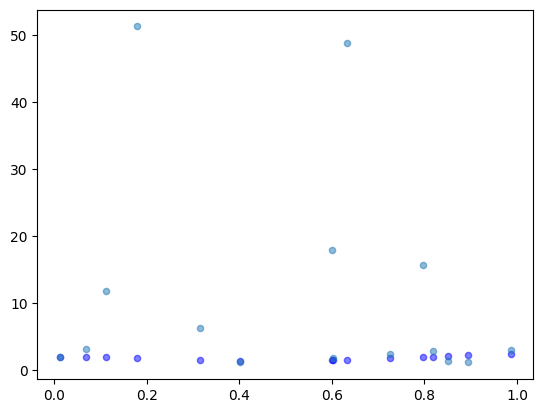

In [191]:
pop = log_specialist.population_log[0]
errors = pop.errors_case
num_cases = errors[0].shape[0]

medians = np.median(errors, axis=0)
epsilon = np.median(np.abs(errors - medians), axis=0)

err = np.abs(errors)
best_errors = np.min(err, axis=0) + epsilon

best_bool = err <= best_errors   
best_inds = np.sum(best_bool, axis=1)

# Get the 5 best individuals
best_inds = np.argsort(best_inds)[::-1][:5]

preds_collection = []

plt.scatter(X_train[:, 0], y_train, c='b', alpha=0.5, s=20)
for ind in best_inds:
    ind = pop[ind]
    # Plot the scatter plot
    preds = ind.predict(X_train)
    preds_collection.append(preds)
    # REmove outliers
    # if np.max(preds) > 50:
    #     # Find the outlier with a mask and then use the mask to plot 
    #     mask = preds < 50
    #     plt.scatter(X_train[mask, 0], preds[mask], alpha=0.5, s=20)
    # 
    # else:
    plt.scatter(X_train[:, 0], preds,  alpha=0.5, s=20)

    break

plt.show()

In [ ]:
for i in range(50):
    print(i)
    pop = log_specialist.population_log[i]

    errors = pop.errors_case
    num_cases = errors[0].shape[0]
    medians = np.median(errors, axis=0)
    epsilon = np.median(np.abs(errors - medians), axis=0)
    err = np.abs(errors)
    best_errors = np.min(err, axis=0) + epsilon
    best_bool = err <= best_errors   
    
    # Sort by the number of best cases
    best_inds = np.sum(best_bool, axis=1)
    best_inds = np.argsort(best_inds)[::-1]
    best_bool = best_bool[best_inds]

    # Plot the best bool with imshow
    plt.imshow(best_bool, aspect='auto')
    plt.colorbar()
    plt.xlabel('Case')
    plt.ylabel('Individual')
    plt.show()

    # time.sleep(3)

### Continuation 

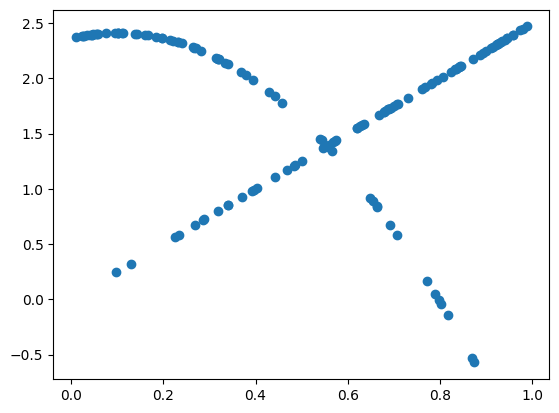

In [14]:
preds = ensemble_tree.predict(X_test)

# Plot the predictions against X_test
plt.scatter(X_test[:,0], preds)
plt.show()

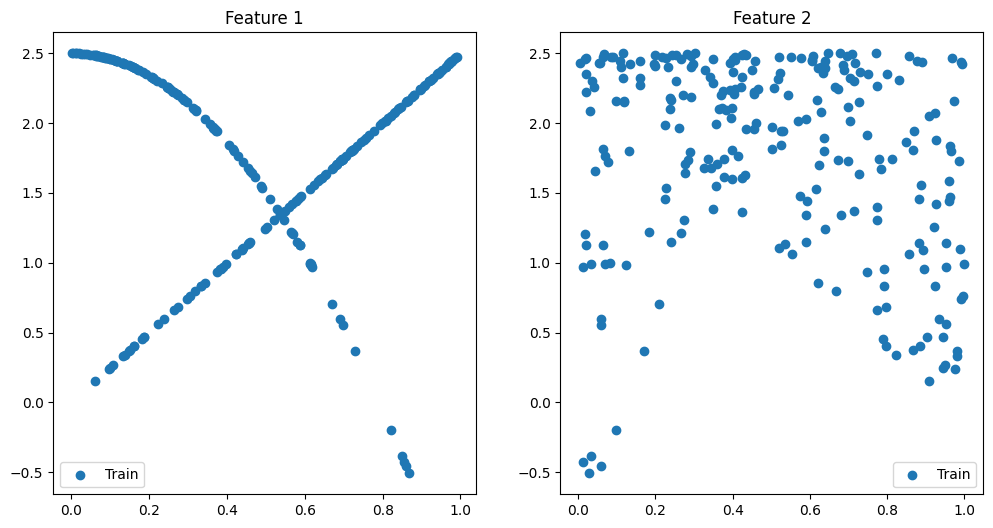

In [108]:
# Plot the scatterplots of the dataset
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], y_train, label='Train')
ax[0].set_title('Feature 1')
ax[0].legend()

ax[1].scatter(X_train[:, 1], y_train, label='Train')
ax[1].set_title('Feature 2')
ax[1].legend()
plt.show()

In [ ]:
tree_1 = Tree(structure=('divide', 'x0', 'constant_0.39'), 
        train_semantics=None, 
        test_semantics=None,
        reconstruct=True)

tree_2 = Tree(structure=('add', 
                         ('divide', 'constant_1.0', 'constant_0.39'),   # 2.56 
                         ('multiply', 
                          ('multiply', 'x0', 'x0'), 
                          ('divide', 'constant_1.0', 'constant__0.25')  # 4 
                          )), 
        train_semantics=None,
        test_semantics=None,
        reconstruct=True)

perfect_1 = Individual([tree_1], None, None, True)
perfect_2 = Individual([tree_2], None, None, True)

perfect_1.calculate_semantics(X_train)
perfect_2.calculate_semantics(X_train)

perfect_1.evaluate(rmse, y_train, operator='mul')
perfect_2.evaluate(rmse, y_train, operator='mul')

perfect_1.version = 'SLIM*ABS'
perfect_2.version = 'SLIM*ABS'

print(perfect_1.fitness, perfect_2.fitness)

In [ ]:
# Plot the predictions of perfect_1 vs dataset and perfect_2 vs dataset
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], y_train, label='Train')
ax[0].scatter(X_train[:, 0], perfect_1.train_semantics, label='Perfect 1')
ax[0].set_title('Feature 1')
ax[0].legend()

ax[1].scatter(X_train[:, 0], y_train, label='Train')
ax[1].scatter(X_train[:, 0], perfect_2.train_semantics, label='Perfect 2')
ax[1].set_title('Feature 2')
ax[1].legend()
plt.show()

In [9]:
seed = 10

slim_params = SlimParameters(pop_size=100, n_iter=1000, max_depth=10, init_depth=4, p_inflate=0.3, p_struct=0.3, n_cases=50,
                             prob_const=0.2, n_elites=0, selector='e_lexicase', decay_rate=0.2, p_xo=0, p_struct_xo=0, 
                             prob_terminal=0.7, mode='exp', elitism=False)

ensemble_tree, population, slim_pop = multi_slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                                params_gp=slim_params, gp_version='SLIM*ABS',
                                full_return=True, seed=seed, verbose=1, pop_size=100, n_iter=2000, p_mut=0.6, 
                                prob_terminal=0.7, prob_specialist=0.7, max_depth=2, depth_condition=3, 
                                test_elite=True, timeout=200)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |      lex_r      |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.890      |      0.954      |      0.009      |        5        |        3        |      2.750      |      2.750      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |   

In [8]:
ensemble_tree.print_tree_representation()

if (
  subtract(
    divide(
      x0
      x0
    )
    add(
      x1
      x0
    )
  )
) > 0 then
  S_51
else
  S_91
endif



In [29]:
slim_pop[24].structure

[(np.str_('add'),
  (np.str_('add'),
   'constant_0.9',
   ('divide', 'constant__0.56', 'constant__0.96')),
  ('add', ('add', 'constant__0.94', 'x0'), ('multiply', 'x0', 'x0'))),
 [<function slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.mutators.two_trees_delta.<locals>.tt_delta(tr1, tr2, ms, testing)>,
  0.10480821841301868]]

In [67]:
# Calculate the correlations between the semantics of slim_pop
for _ in range(200):
    semantics = np.array([ind.train_semantics for ind in slim_pop])
    correlation = np.corrcoef(semantics)
# plt.imshow(correlation, cmap='viridis')
# plt.colorbar()
# plt.show()

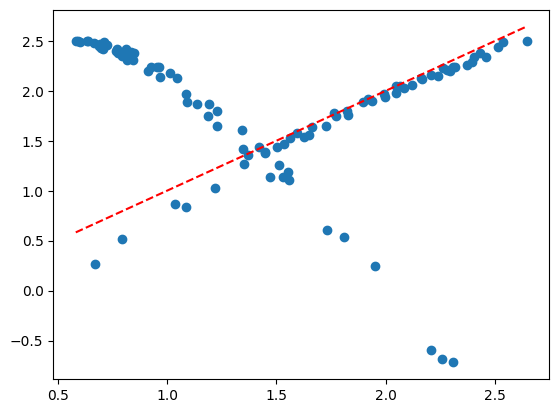

In [51]:
i = 50
plt.scatter(slim_pop[i].predict(X_train), y_train)
range_ = np.linspace(min(slim_pop[i].predict(X_train)), max(slim_pop[i].predict(X_train)), 100)
plt.plot(range_, range_, 'r--')
plt.show()

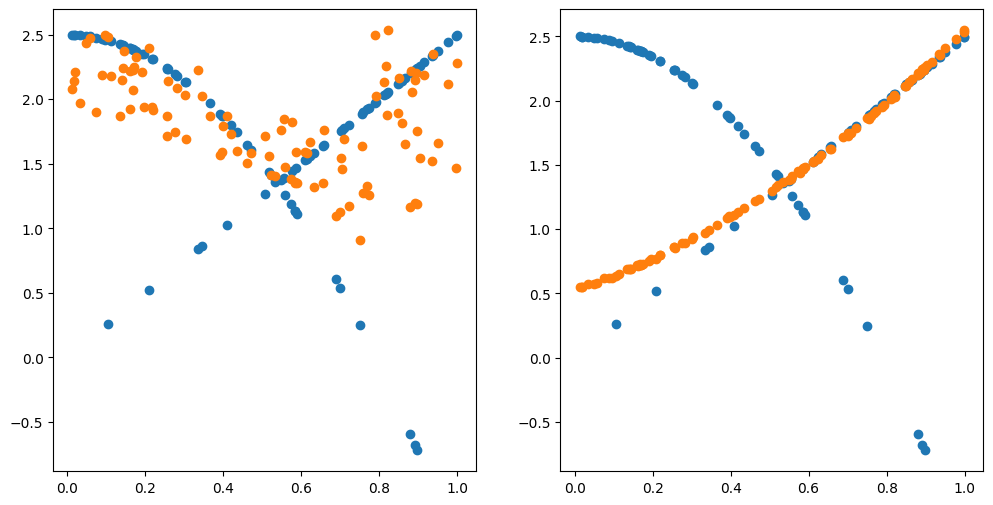

In [54]:
preds_1, preds_2 = slim_pop[0].predict(X_train), slim_pop[24].predict(X_train)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(X_train[:, 0], y_train, label='Train')
axs[0].scatter(X_train[:, 0], preds_1, label='SLIM 1')

axs[1].scatter(X_train[:, 0], y_train, label='Train')
axs[1].scatter(X_train[:, 0], preds_2, label='SLIM 2')
plt.show()

In [71]:
ensemble_tree.print_tree_representation()

if (
  subtract(
    multiply(
      x0
      x2
    )
    multiply(
      x2
      constant_0.45
    )
  )
) > 0 then
  S_243
else
  S_231
endif



In [11]:
slim_pop[0].structure

[(np.str_('add'),
  ('add',
   ('divide',
    ('multiply', 'constant__0.56', ('multiply', 'x0', 'constant_0.29')),
    ('divide', 'x1', 'x0')),
   ('subtract', ('divide', 'x1', 'x1'), 'constant__0.52')),
  ('subtract', ('divide', 'x0', 'x0'), 'x1'))]

Removed 6 Pareto-dominated individuals
Removed 3 individuals due to similarity


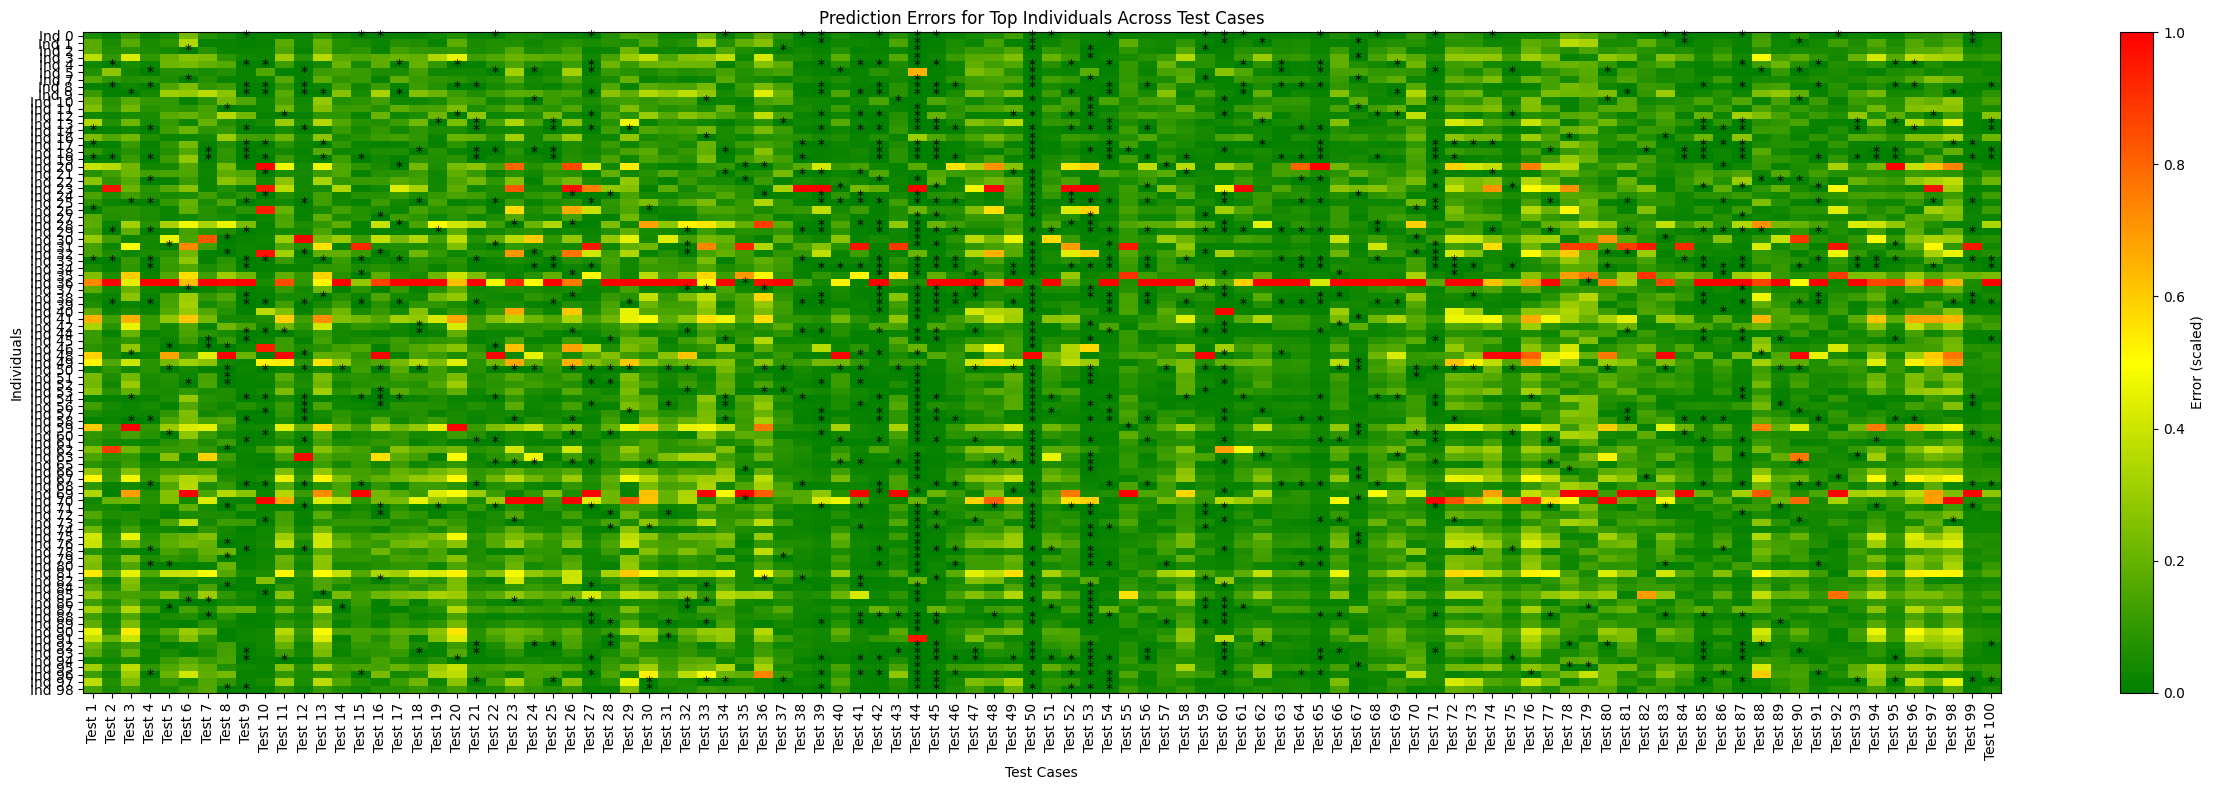

Maximum number of True values: 69 of 100
Best combinations of rows (indices in `errors`): [(6, 50), (19, 50), (33, 50), (50, 99)]
Total error of the ensemble: 0.261 vs 0.846 (-0.586)
Individual 6 covers 33 cases
Individual 50 covers 36 cases


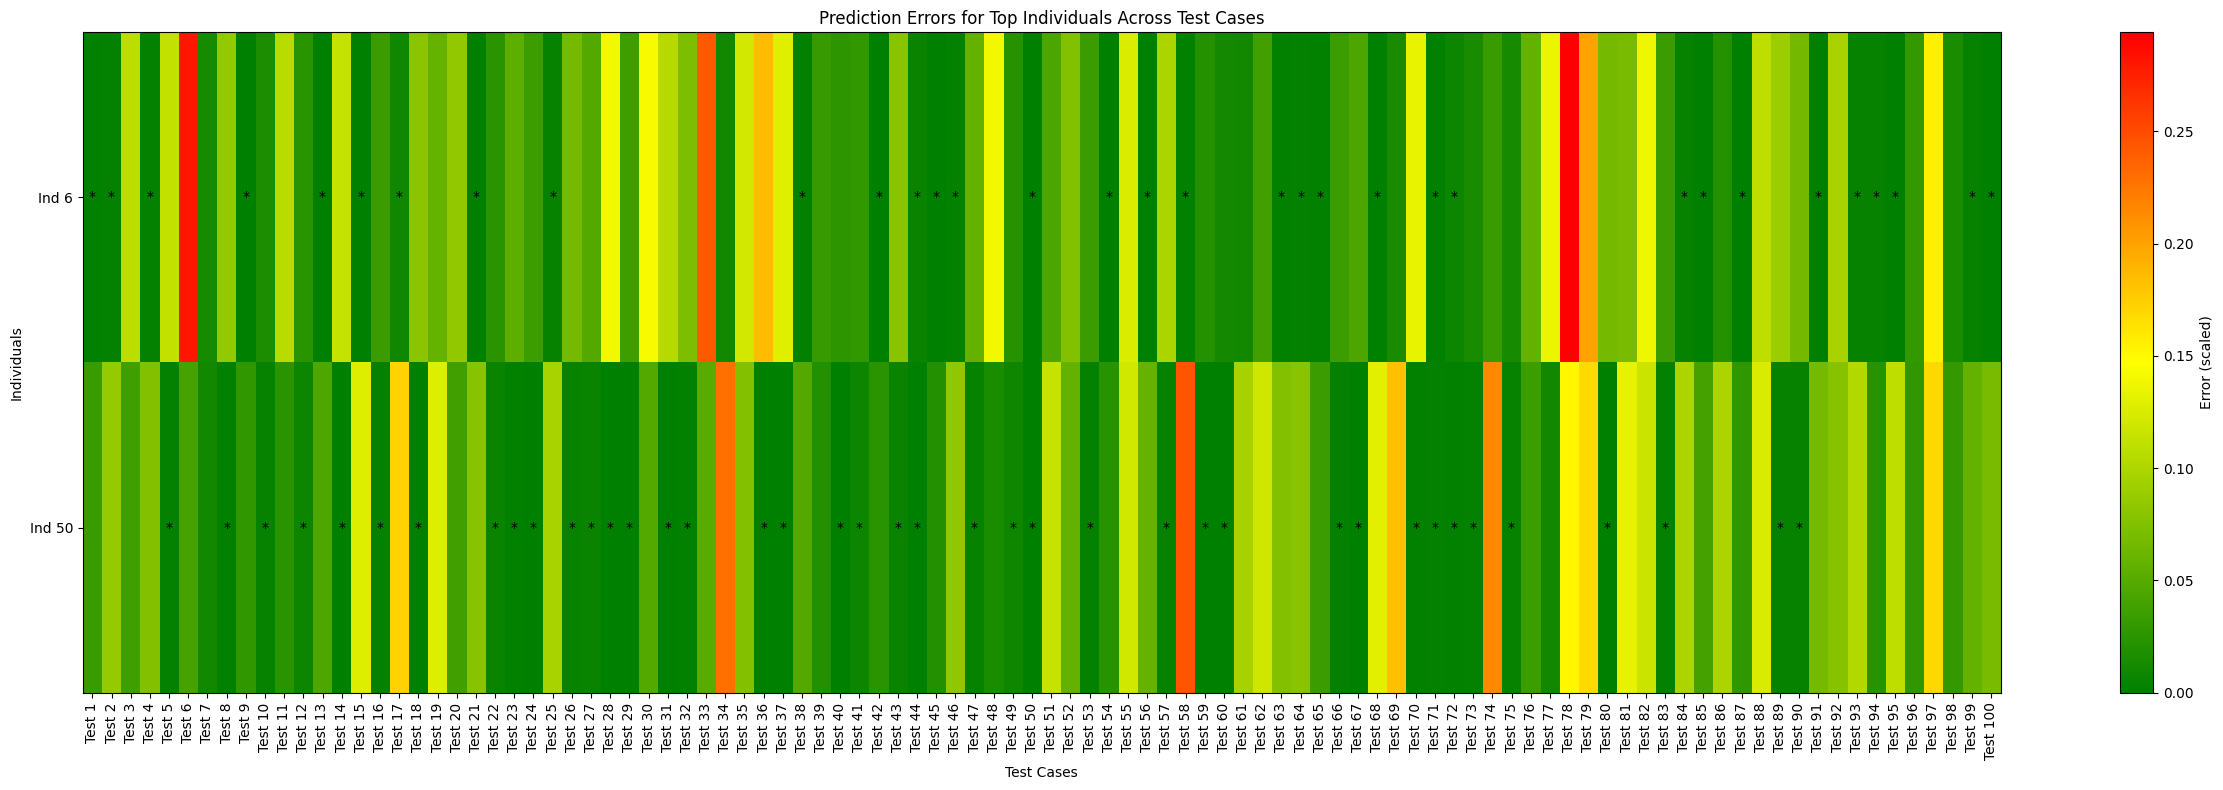

In [15]:
similarity_threshold = 0
threshold = 0.01

errors, unique_indices = simplify_population(slim_pop, X_train, y_train, similarity_threshold=similarity_threshold)
plot_errors(errors, unique_indices, threshold=threshold)
errors, chosen_indices = combine_simplify(slim_pop, X_train, y_train, threshold=threshold, n=2)
plot_errors(errors, chosen_indices, threshold=threshold)

#### SPECIALISTS FINDING METRIC ?


Pairwise Distance Matrix (Manhattan/Hamming Distance):
        I1    I2    I3    I4    I5    I6    I7    I8    I9   I10  ...   I91  \
I1     0.0  18.0  18.0  33.0  45.0  56.0  40.0  41.0  25.0  56.0  ...  38.0   
I2    18.0   0.0   0.0  15.0  27.0  38.0  22.0  23.0   7.0  38.0  ...  20.0   
I3    18.0   0.0   0.0  15.0  27.0  38.0  22.0  23.0   7.0  38.0  ...  20.0   
I4    33.0  15.0  15.0   0.0  42.0  53.0  37.0  38.0  22.0  53.0  ...  35.0   
I5    45.0  27.0  27.0  42.0   0.0  65.0  49.0  50.0  34.0  65.0  ...  47.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
I96   30.0  12.0  12.0  27.0  39.0  50.0  34.0  35.0  19.0  50.0  ...  32.0   
I97   23.0   5.0   5.0  20.0  32.0  43.0  27.0  28.0  12.0  43.0  ...  25.0   
I98   20.0   2.0   2.0  17.0  25.0  40.0  24.0  25.0   9.0  40.0  ...  22.0   
I99   45.0  27.0  27.0  42.0   0.0  65.0  49.0  50.0  34.0  65.0  ...  47.0   
I100  45.0  27.0  27.0  42.0  54.0  65.0  49.0  50.0  34.0  65.0  ...  47.0

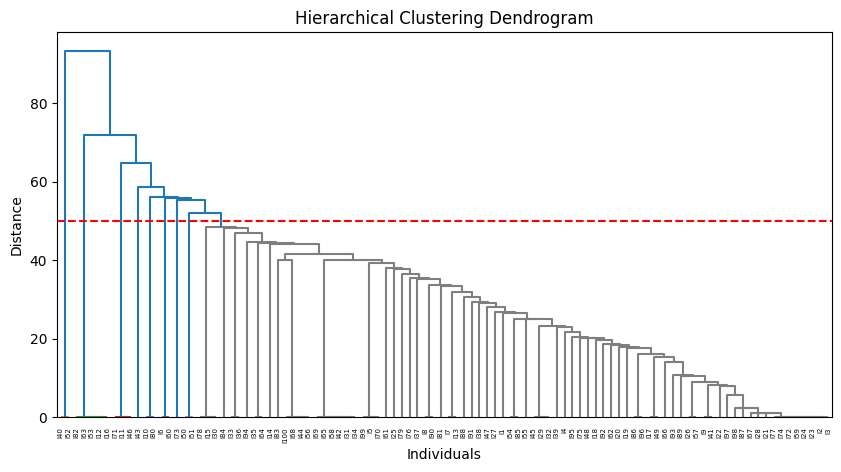


Cluster Assignments:
   Individual  Cluster
51        I52        1
39        I40        1
15        I16        2
11        I12        2
62        I63        2
..        ...      ...
96        I97        7
99       I100        7
97        I98        7
72        I73        8
42        I43        9

[100 rows x 2 columns]
Cluster
7    82
2     5
3     3
4     2
5     2
1     2
6     2
9     1
8     1
Name: count, dtype: int64


: 

In [ ]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# PARAMS 
tau = 1e-2
threshold = 50

error_matrix = np.abs(population.errors_case)

# Step 2: Compute the minimum error per test case (column-wise)
min_errors = np.min(error_matrix, axis=0)

# Step 3: Convert to elitized binary matrix (0 if minimum, 1 otherwise)
elitized_matrix = (error_matrix <= min_errors + np.median(min_errors)*tau).astype(int)

# Step 4: Compute pairwise Manhattan (Hamming) distances
distance_matrix = squareform(pdist(elitized_matrix, metric="cityblock"))

# Convert to DataFrame for better readability
individuals = [f"I{i+1}" for i in range(100)]
distance_df = pd.DataFrame(distance_matrix, index=individuals, columns=individuals)

# Print the pairwise distance matrix
print("\nPairwise Distance Matrix (Manhattan/Hamming Distance):")
print(distance_df)

# Compute pairwise condensed Manhattan (Hamming) distances
condensed_distance = pdist(elitized_matrix, metric="cityblock")  

# Perform hierarchical clustering with the condensed distance matrix
linkage_matrix = sch.linkage(condensed_distance, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix, labels=individuals, leaf_rotation=90, color_threshold=threshold)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Individuals")
plt.ylabel("Distance")
plt.axhline(y=threshold, color='r', linestyle='--')  # Example threshold for cutting clusters
plt.show()

from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Print cluster assignments
cluster_df = pd.DataFrame({"Individual": individuals, "Cluster": clusters})
print("\nCluster Assignments:")
print(cluster_df.sort_values(by="Cluster"))

print(cluster_df['Cluster'].value_counts())

#### FUNCTIONS 

In [12]:
def is_pareto_non_dominated(errors): 
    """
    Function to determine if a set of errors is Pareto non-dominated
    
    Returns
    --------
        Array of boolean values indicating if each individual is non-dominated
    """
    n_individuals = errors.shape[0]
    is_non_dominated = np.ones(n_individuals, dtype=bool)
    
    for i in range(n_individuals):
        for j in range(n_individuals):
            if i == j:
                continue
            if all(errors[i] <= errors[j]) and any(errors[i] < errors[j]):
                is_non_dominated[j] = False
    return is_non_dominated


def simplify_population(population, X_train, y_train, similarity_threshold=0.1):
    version = population.population[0].version
    for ind in population:
        ind.version = version
    best_individuals = sorted(population, key=lambda x: x.size)[:100]
    
    errors = np.array([np.abs(ind.predict(X_train) - y_train) for ind in best_individuals])
    
    pareto_mask = is_pareto_non_dominated(errors)
    pareto_indices = [i for i, mask in enumerate(pareto_mask) if mask]
    
    print(f"Removed {len(best_individuals) - len(pareto_indices)} Pareto-dominated individuals")
    
    errors = MinMaxScaler().fit_transform(errors)
    
    # Compute pairwise distances
    distance_matrix = squareform(pdist(errors, metric='euclidean'))
    mean_distance = distance_matrix.mean()
    
    # Select unique individuals based on similarity threshold
    unique_indices = []
    for i in pareto_indices:
        if not unique_indices or all(distance_matrix[i, j] > similarity_threshold * mean_distance for j in unique_indices):
            unique_indices.append(i)
    
    print(f"Removed {len(pareto_indices) - len(unique_indices)} individuals due to similarity")
    
    return errors[unique_indices], unique_indices

def plot_errors(errors, unique_indices, threshold=0.1):
    plt.figure(figsize=(25, 8))
    plt.imshow(errors, cmap=LinearSegmentedColormap.from_list("GreenRed", ["green", "yellow", "red"]), aspect="auto")
    plt.colorbar(label="Error (scaled)", orientation="vertical")
    
    for i, row in enumerate(errors):
        for j, val in enumerate(row):
            if val < threshold:
                plt.text(j, i, "*", color="black", ha="center", va="center", fontsize=10)
    
    plt.title("Prediction Errors for Top Individuals Across Test Cases")
    plt.xlabel("Test Cases")
    plt.ylabel("Individuals")
    plt.xticks(range(errors.shape[1]), [f"Test {i+1}" for i in range(errors.shape[1])], rotation=90)
    plt.yticks(range(errors.shape[0]), [f"Ind {idx}" for idx in unique_indices])
    plt.tight_layout()
    plt.show()

def combine_simplify(population, X_train, y_train, threshold=0.1, n=2):
    best_individuals = sorted(population, key=lambda x: x.size)[:100]
    errors = np.array([np.abs(ind.predict(X_train) - y_train) for ind in best_individuals])
    
    scaler = MinMaxScaler()
    scaled_errors = scaler.fit_transform(errors)
    
    bool_array = scaled_errors < threshold
    max_trues = 0
    best_combinations = []

    for comb in combinations(range(bool_array.shape[0]), n):
        combined_row = np.logical_or.reduce(bool_array[list(comb), :])
        true_count = np.sum(combined_row)
        if true_count > max_trues:
            max_trues = true_count
            best_combinations = [comb]
        elif true_count == max_trues:
            best_combinations.append(comb)

    print(f"Maximum number of True values: {max_trues} of {bool_array.shape[1]}")
    print(f"Best combinations of rows (indices in `errors`): {best_combinations}")

    if not best_combinations:
        print("No valid combinations found.")
        return scaled_errors, list(range(scaled_errors.shape[0]))

    # Choose one of the best combinations (e.g., the first one)
    chosen_combination = best_combinations[0]
    
    ensemble_indices = []
    individual_contributions = {}
    ensemble_errors = np.zeros(errors.shape[1])

    for individual_idx in chosen_combination:
        individual_cases = np.where(bool_array[individual_idx] & ~np.isin(range(errors.shape[1]), ensemble_indices))[0]
        individual_contributions[individual_idx] = individual_cases
        ensemble_indices.extend(individual_cases)
        ensemble_errors[individual_cases] = errors[individual_idx, individual_cases]

    total_error_ensemble = np.sqrt(np.mean(ensemble_errors))
    total_error_no_ensemble = np.sqrt(np.mean(np.mean(errors[list(chosen_combination)], axis=0)))

    print(f"Total error of the ensemble: {round(total_error_ensemble,3)} vs {round(total_error_no_ensemble,3)} ({round(total_error_ensemble-total_error_no_ensemble,3)})")

    for i, (individual_idx, cases) in enumerate(individual_contributions.items()):
        print(f"Individual {individual_idx} covers {len(cases)} cases")

    return scaled_errors[list(chosen_combination)], list(chosen_combination)

In [12]:
similarity_threshold = 0.2 
threshold = 0.025

errors, unique_indices = simplify_population(population, X_train, y_train, similarity_threshold=similarity_threshold)
plot_errors(errors, unique_indices, threshold=threshold)
errors, chosen_indices = combine_simplify(population, X_train, y_train, example_tree, threshold=threshold, similarity_threshold=similarity_threshold, n=2)
plot_errors(errors, chosen_indices, threshold=threshold)

AttributeError: 'Tree' object has no attribute 'size'

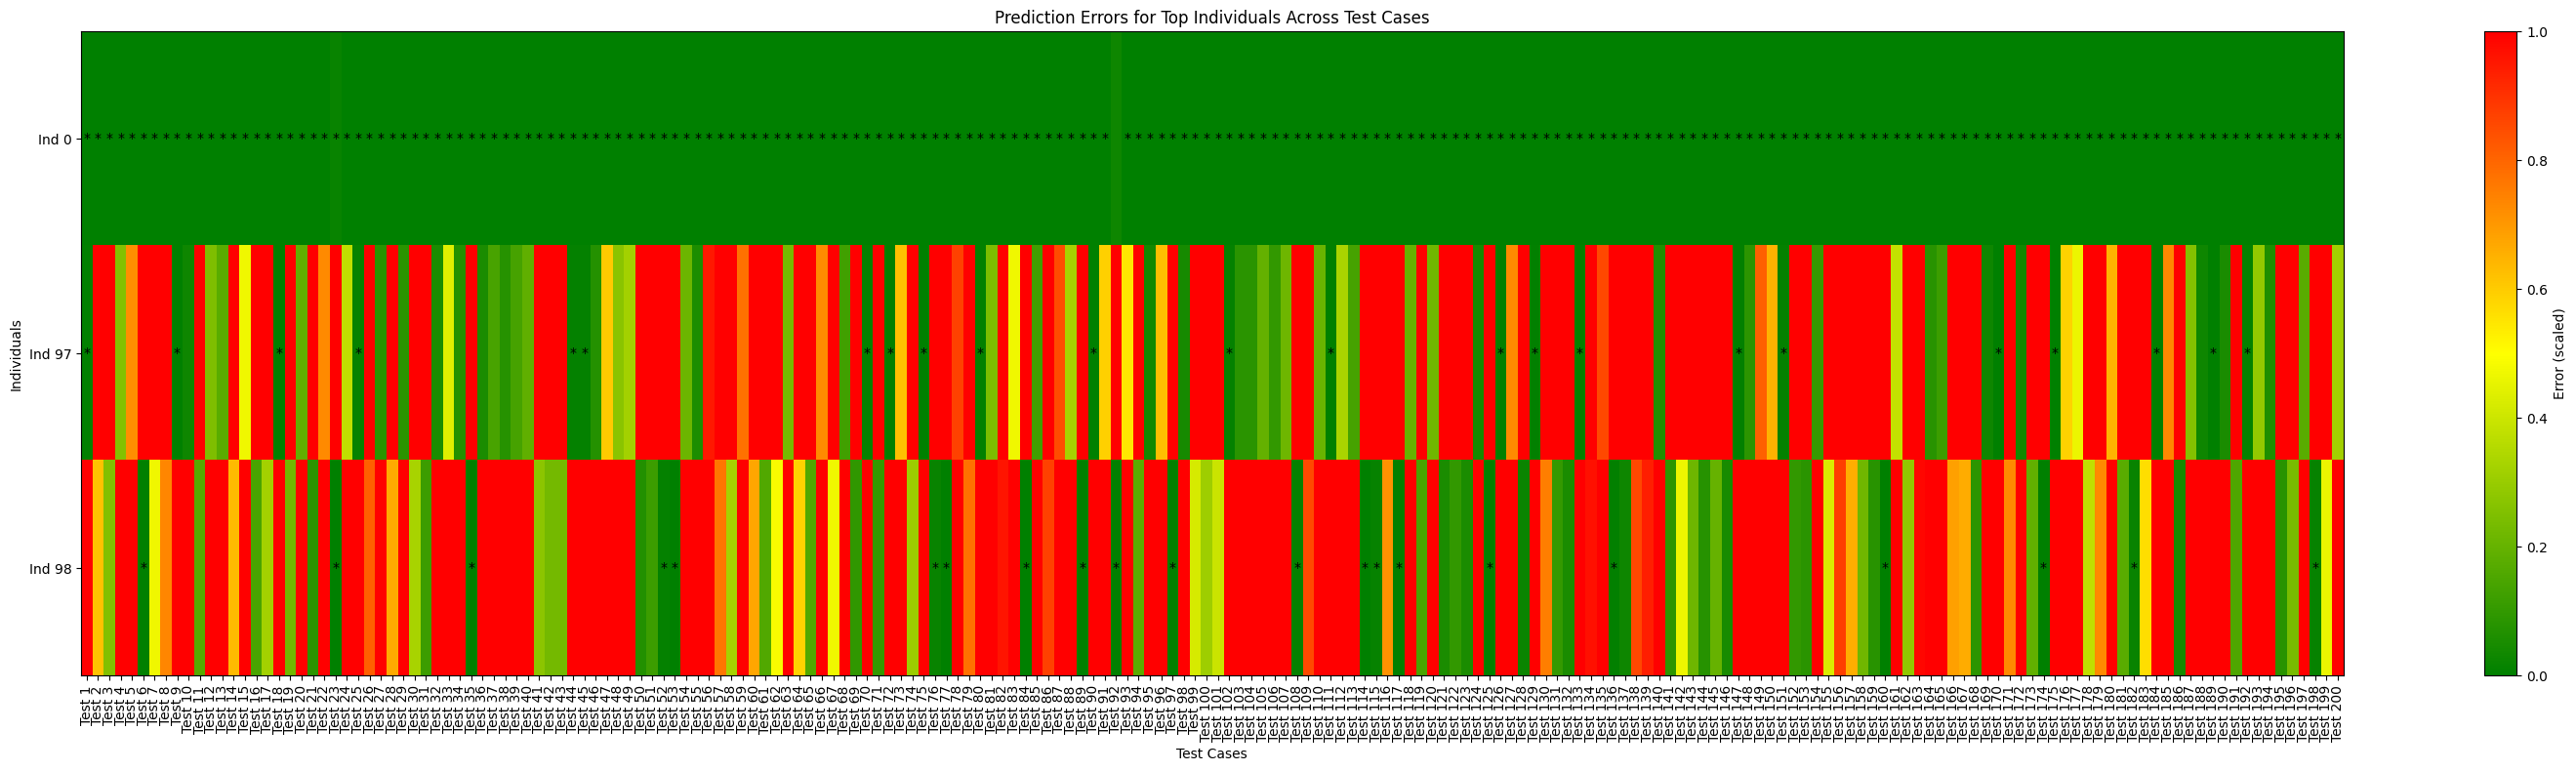

In [553]:
best_individuals = sorted(population, key=lambda x: x.fitness)[:99]
errors = []
individual_indices = []  # To track which individual corresponds to each row
threshold = 0.02
similarity_threshold = 0.5

# Calculate errors for each individual
for idx, individual in enumerate(best_individuals):
    individual.version = example_tree.version
    error = (individual.predict(X_train) - y_train) ** 2  # Squared error
    errors.append(error)
    individual_indices.append(idx)  # Keep track of the individual index

# Convert errors to a 2D array (rows = individuals, columns = test cases)
errors = np.array(errors)

# Compute pairwise distances between individuals
distance_matrix = squareform(pdist(errors, metric='euclidean'))
mean_distance = distance_matrix.mean()

# Select unique individuals based on similarity threshold
unique_indices = []
selected_individuals = []  # To keep track of selected individuals
for i, row in enumerate(errors):
    if all(distance_matrix[i, j] > similarity_threshold * mean_distance for j in unique_indices):
        unique_indices.append(i)
        selected_individuals.append(individual_indices[i])  # Map back to original individual index

# Filter errors and scale
errors = errors[unique_indices]
scaler = MinMaxScaler()
errors = scaler.fit_transform(errors)

# Sort errors by the number of values below the threshold
sorted_indices = np.sum(errors < threshold, axis=1).argsort()[::-1]
errors = errors[sorted_indices]
sorted_individuals = [selected_individuals[i] for i in sorted_indices]  # Update individual mapping

# Create a colormap for the plot
colors = LinearSegmentedColormap.from_list("GreenRed", ["green", "yellow", "red"])

# Plot the diagram
plt.figure(figsize=(30, 8))
plt.imshow(errors, cmap=colors, aspect="auto")
plt.colorbar(label="Error (scaled)", orientation="vertical")

# Add labels for values that are close to zero
for i in range(errors.shape[0]):  # Iterate over individuals
    for j in range(errors.shape[1]):  # Iterate over test cases
        if errors[i, j] < threshold:
            plt.text(j, i, "*", color="black", ha="center", va="center", fontsize=10)

# Add labels and titles
plt.title("Prediction Errors for Top Individuals Across Test Cases")
plt.xlabel("Test Cases")
plt.ylabel("Individuals")
plt.xticks(range(errors.shape[1]), labels=[f"Test {i+1}" for i in range(errors.shape[1])], rotation=90)
plt.yticks(range(errors.shape[0]), labels=[f"Ind {idx}" for idx in sorted_individuals])
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
seed = 2

X,y = datasets[2]()
# Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=0)

agelog = LogAge()
divlog = LogDiversity()
early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train,
                    dataset_name='test', test_elite=False, slim_version='SLIM*ABS', # initializer='simple',
                    max_depth=15, init_depth=5, pop_size=100, n_iter=500, seed=seed, verbose=1,
                    p_inflate=0.5, p_struct=0.2,
                    prob_const=0.06, n_elites=1, selector='lexicase', 
                    decay_rate=0.2, p_xo=0, p_struct_xo=0,
                    callbacks=[agelog, divlog, early_stop],
                    tournament_size=10, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()

TypeError: selector() got an unexpected keyword argument 'eps_fraction'

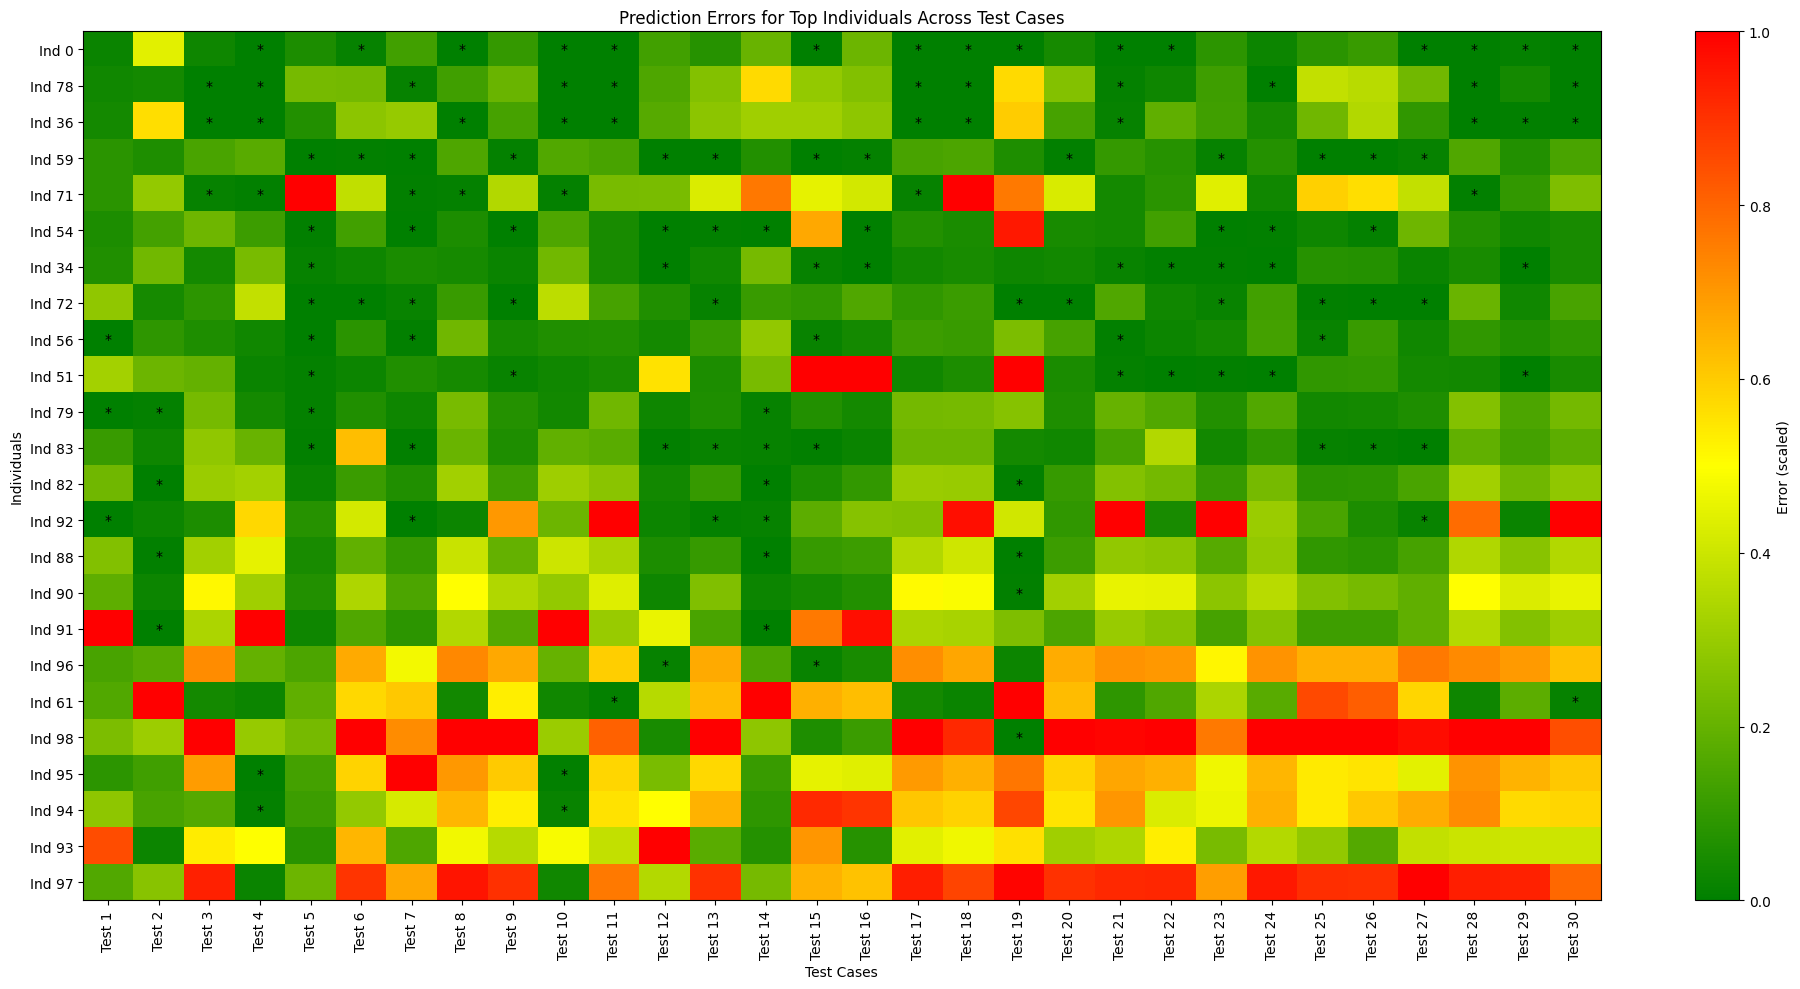

In [580]:
best_individuals = sorted(population, key=lambda x: x.fitness)[:99]
errors = []
individual_indices = []  # To track which individual corresponds to each row
threshold = 0.02
similarity_threshold = 0.4

# Calculate errors for each individual
for idx, individual in enumerate(best_individuals):
    individual.version = example_tree.version
    error = (individual.predict(X_train) - y_train) ** 2  # Squared error
    errors.append(error)
    individual_indices.append(idx)  # Keep track of the individual index

# Convert errors to a 2D array (rows = individuals, columns = test cases)
errors = np.array(errors)

# Compute pairwise distances between individuals
distance_matrix = squareform(pdist(errors, metric='euclidean'))
mean_distance = distance_matrix.mean()

# Select unique individuals based on similarity threshold
unique_indices = []
selected_individuals = []  # To keep track of selected individuals
for i, row in enumerate(errors):
    if all(distance_matrix[i, j] > similarity_threshold * mean_distance for j in unique_indices):
        unique_indices.append(i)
        selected_individuals.append(individual_indices[i])  # Map back to original individual index

# Filter errors and scale
errors = errors[unique_indices]
scaler = MinMaxScaler()
errors = scaler.fit_transform(errors)

# Sort errors by the number of values below the threshold
sorted_indices = np.sum(errors < threshold, axis=1).argsort()[::-1]
errors = errors[sorted_indices]
sorted_individuals = [selected_individuals[i] for i in sorted_indices]  # Update individual mapping

# Create a colormap for the plot
errors = errors[:,100:130]
colors = LinearSegmentedColormap.from_list("GreenRed", ["green", "yellow", "red"])

# Plot the diagram
plt.figure(figsize=(20, 10))
plt.imshow(errors, cmap=colors, aspect="auto")
plt.colorbar(label="Error (scaled)", orientation="vertical")

# Add labels for values that are close to zero
for i in range(errors.shape[0]):  # Iterate over individuals
    for j in range(errors.shape[1]):  # Iterate over test cases
        if errors[i, j] < threshold:
            plt.text(j, i, "*", color="black", ha="center", va="center", fontsize=10)

# Add labels and titles
plt.title("Prediction Errors for Top Individuals Across Test Cases")
plt.xlabel("Test Cases")
plt.ylabel("Individuals")
plt.xticks(range(errors.shape[1]), labels=[f"Test {i+1}" for i in range(errors.shape[1])], rotation=90)
plt.yticks(range(errors.shape[0]), labels=[f"Ind {idx}" for idx in sorted_individuals])
plt.tight_layout()

# Show the plot
plt.show()

In [176]:
y_train = y_train[:20]
X_train = X_train[:20]

Removed 34 Pareto-dominated individuals out of 100
Removed 27 individuals due to similarity out of 66


ValueError: The number of FixedLocator locations (39), usually from a call to set_ticks, does not match the number of labels (24).

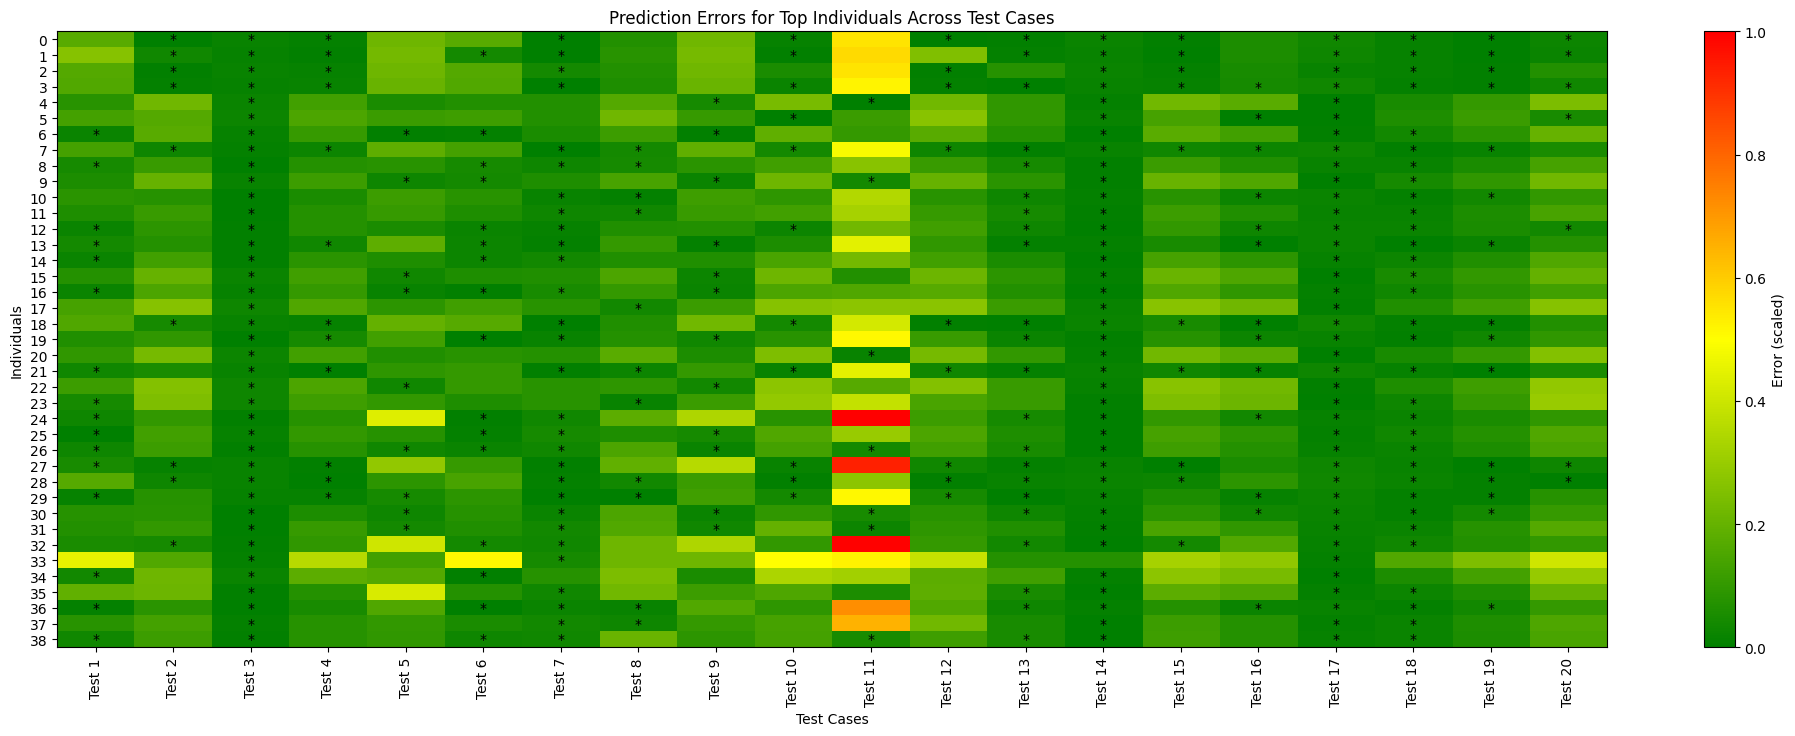

In [263]:
best_individuals = sorted(population, key=lambda x: x.size)[:100]
errors = []
individual_indices = []  # To track which individual corresponds to each row
threshold = 0.05

# Calculate errors for each individual
for idx, individual in enumerate(best_individuals):
    individual.version = example_tree.version
    error = np.abs((individual.predict(X_train) - y_train))
    errors.append(error)
    individual_indices.append(idx)  # Keep track of the individual index

errors = np.array(errors)

# Find Pareto-efficient individuals
pareto_mask = is_pareto_non_dominated(errors)
pareto_nondominated_ids = [idx for idx, mask in zip(individual_indices, pareto_mask) if mask]

# Calculate removal statistics
removed_count = len(best_individuals) - len(pareto_nondominated_ids)
print(f"Removed {removed_count} Pareto-dominated individuals out of {len(best_individuals)}")

# Use minmax scaling
scaler = MinMaxScaler()
errors = scaler.fit_transform(errors)
bellow_threshold = (errors < threshold)

# Remove individuals that are perfectly similar 
unique_indices = []
for i in pareto_nondominated_ids:
    if len(unique_indices) == 0:
        unique_indices.append(i)
        continue
    unique = True
    # If the individual is equal to any of the unique individuals, skip
    for j in unique_indices:
        if all(bellow_threshold[i] == bellow_threshold[j]):
            unique = False
            break
    if unique:
        unique_indices.append(i)

# Filter errors and scale
errors = errors[unique_indices]
# Print how many individuals were removed accounting for the previous removal
print(f"Removed {len(pareto_nondominated_ids) - len(unique_indices)} individuals due to similarity out of {len(pareto_nondominated_ids)}")


colors = LinearSegmentedColormap.from_list("GreenRed", ["green", "yellow", "red"])

# Plot the diagram
plt.figure(figsize=(25, 8))
plt.imshow(errors, cmap=colors, aspect="auto")
plt.colorbar(label="Error (scaled)", orientation="vertical")

# Add labels for values that are close to zero
for i in range(errors.shape[0]):  # Iterate over individuals
    for j in range(errors.shape[1]):  # Iterate over test cases
        if errors[i, j] < threshold:
            plt.text(j, i, "*", color="black", ha="center", va="center", fontsize=10)

# Add labels and titles
plt.title("Prediction Errors for Top Individuals Across Test Cases")
plt.xlabel("Test Cases")
plt.ylabel("Individuals")
plt.xticks(range(errors.shape[1]), labels=[f"Test {i+1}" for i in range(errors.shape[1])], rotation=90)
plt.yticks(range(errors.shape[0]), labels=[f"Ind {idx}" for idx in sorted_individuals])
plt.tight_layout()

# Show the plot
plt.show()

In [260]:
len(unique_indices)

39

In [249]:
bellow_threshold

array([[False, False,  True, ...,  True,  True, False],
       [False, False,  True, ...,  True,  True, False],
       [False, False,  True, ...,  True,  True, False],
       ...,
       [ True, False,  True, ...,  True, False, False],
       [ True, False,  True, ...,  True, False, False],
       [False, False, False, ..., False, False, False]])

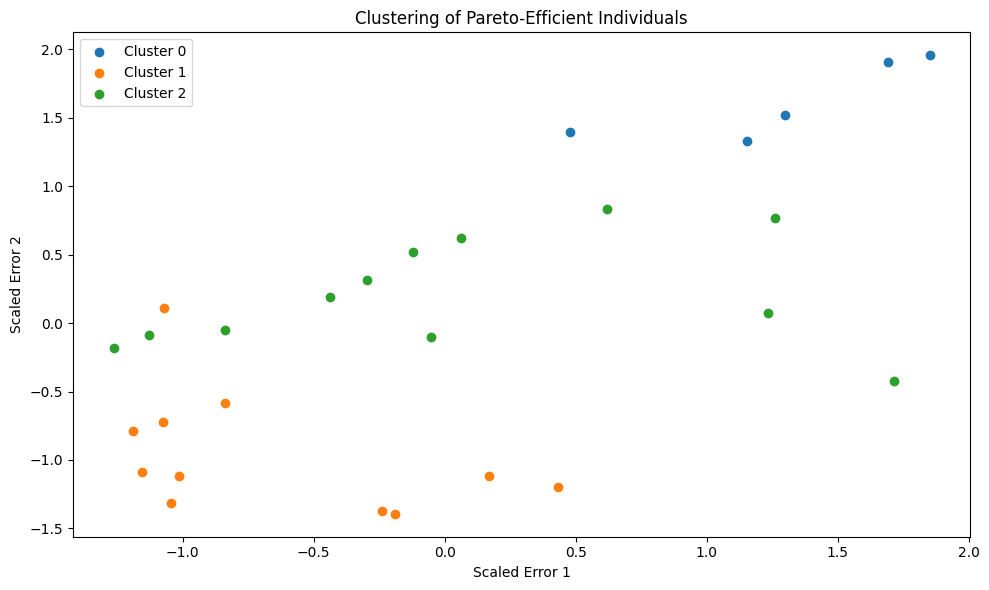

In [94]:
# Use k-means clustering to identify clusters
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the errors
scaler = StandardScaler()
scaled_errors = scaler.fit_transform(errors)

# Perform clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaled_errors)
cluster_labels = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 6))

# Plot the clusters
for i in range(n_clusters):
    plt.scatter(scaled_errors[cluster_labels == i, 0], scaled_errors[cluster_labels == i, 1], label=f"Cluster {i}")

# Add labels and titles
plt.xlabel("Scaled Error 1")
plt.ylabel("Scaled Error 2")
plt.title("Clustering of Pareto-Efficient Individuals")
plt.legend()
plt.tight_layout()


<Axes: ylabel='Density'>

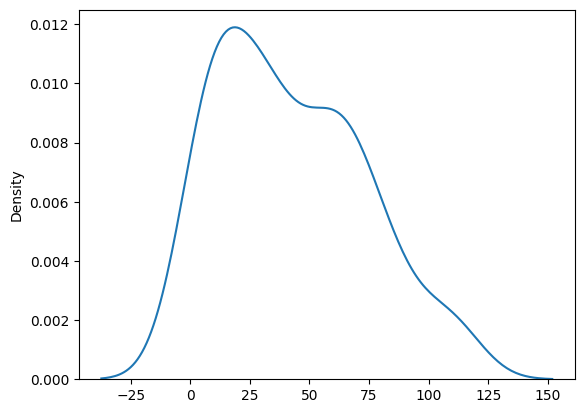

In [73]:
# PLot errors[:,12] distribution kdistplot
import seaborn as sns
sns.kdeplot(errors[:, 10])


In [ ]:
best_individuals = population
errors = []
individual_indices = []  # To track which individual corresponds to each row
threshold = 0.02
similarity_threshold = 0.4

# Calculate errors for each individual
for idx, individual in enumerate(best_individuals):
    individual.version = example_tree.version
    error = (individual.predict(X_train) - y_train) ** 2  # Squared error
    errors.append(error)
    individual_indices.append(idx)  # Keep track of the individual index

# Convert errors to a 2D array (rows = individuals, columns = test cases)
errors = np.array(errors)

# Compute pairwise distances between individuals
distance_matrix = squareform(pdist(errors, metric='euclidean'))
mean_distance = distance_matrix.mean()

# Select unique individuals based on similarity threshold
unique_indices = []
selected_individuals = []  # To keep track of selected individuals
for i, row in enumerate(errors):
    if all(distance_matrix[i, j] > similarity_threshold * mean_distance for j in unique_indices):
        unique_indices.append(i)
        selected_individuals.append(individual_indices[i])  # Map back to original individual index

# Filter errors and scale
errors = errors[unique_indices]
scaler = MinMaxScaler()
errors = scaler.fit_transform(errors)

# Sort errors by the number of values below the threshold
sorted_indices = np.sum(errors < threshold, axis=1).argsort()[::-1]
errors = errors[sorted_indices]
sorted_individuals = [selected_individuals[i] for i in sorted_indices]  # Update individual mapping

# Create a colormap for the plot
colors = LinearSegmentedColormap.from_list("GreenRed", ["green", "yellow", "red"])

# Plot the diagram
plt.figure(figsize=(25, 8))
plt.imshow(errors, cmap=colors, aspect="auto")
plt.colorbar(label="Error (scaled)", orientation="vertical")

# Add labels for values that are close to zero
for i in range(errors.shape[0]):  # Iterate over individuals
    for j in range(errors.shape[1]):  # Iterate over test cases
        if errors[i, j] < threshold:
            plt.text(j, i, "*", color="black", ha="center", va="center", fontsize=10)

# Add labels and titles
plt.title("Prediction Errors for Top Individuals Across Test Cases")
plt.xlabel("Test Cases")
plt.ylabel("Individuals")
plt.xticks(range(errors.shape[1]), labels=[f"Test {i+1}" for i in range(errors.shape[1])], rotation=90)
plt.yticks(range(errors.shape[0]), labels=[f"Ind {idx}" for idx in sorted_individuals])
plt.tight_layout()

# Show the plot
plt.show()

In [262]:
n = 3

bool_array = errors < threshold
max_trues = 0
best_combinations = []

# Iterate over all combinations of n rows
for comb in combinations(range(bool_array.shape[0]), n):
    combined_row = np.logical_or.reduce(bool_array[list(comb), :])
    true_count = np.sum(combined_row)
    if true_count > max_trues:
        max_trues = true_count
        best_combinations = [comb]
    elif true_count == max_trues:
        best_combinations.append(comb)

# Map combinations back to the original individuals
best_individuals_combinations = [
    [sorted_individuals[row] for row in comb] for comb in best_combinations
]

# Output results
print(f"Maximum number of True values: {max_trues} of {bool_array.shape[1]}")
print(f"Best combinations of rows (indices in `errors`): {best_combinations}")
print(f"Best combinations of individuals (indices in `best_individuals`): {best_individuals_combinations}")
print('-'*50)

# Example variables
bool_array = errors < threshold  # Boolean array (True where error < threshold)
mapped_combinations = best_combinations[0]

ensemble_indices = []  # Track indices of cases covered by the ensemble
individual_contributions = {}  # Track individual contributions
ensemble_errors = np.zeros(errors.shape[1])  # Placeholder for ensemble errors

# Unscale the errors using the inverse transformation
unscaled_errors = scaler.inverse_transform(errors)

# Calculate the overall unscaled error without ensemble
average_error_no_ensemble_unscaled = np.mean(unscaled_errors[mapped_combinations[0]], axis=0)
total_error_no_ensemble_unscaled = np.sqrt(np.mean(average_error_no_ensemble_unscaled))

# Iterate through individuals in the mapped combination
for individual_idx in mapped_combinations:
    # Identify cases where the individual excels
    individual_cases = np.where(bool_array[individual_idx] & ~np.isin(range(errors.shape[1]), ensemble_indices))[0]
    
    # Track individual contributions
    individual_contributions[individual_idx] = individual_cases
    
    # Add these cases to the ensemble indices
    ensemble_indices.extend(individual_cases)

    # Update the ensemble errors for these cases
    ensemble_errors[individual_cases] = unscaled_errors[individual_idx, individual_cases]

# Calculate the overall unscaled error of the ensemble
total_error_ensemble_unscaled = np.sqrt(np.mean(ensemble_errors))

# Output results
print(f"Total unscaled error of the ensemble: {round(total_error_ensemble_unscaled,3)} vs {round(total_error_no_ensemble_unscaled,3)} ({round(total_error_ensemble_unscaled-total_error_no_ensemble_unscaled,3)})")

print(f"Cases covered by each individual in the ensemble:")
for i, (individual_idx, cases) in enumerate(individual_contributions.items()):
    print(f"Individual {best_individuals_combinations[0][i]} covers {len(cases)} cases")

Maximum number of True values: 1160 of 1203
Best combinations of rows (indices in `errors`): [(0, 3, 12)]
Best combinations of individuals (indices in `best_individuals`): [[0, 59, 82]]
--------------------------------------------------
Total unscaled error of the ensemble: 14.052 vs 30.002 (-15.949)
Cases covered by each individual in the ensemble:
Individual 0 covers 670 cases
Individual 59 covers 338 cases
Individual 82 covers 152 cases


In [18]:
# Use the 10 best individuals to test the ensemble
best_individuals = sorted(population, key=lambda x: x.fitness)[:2]
ensemble_preds = []
for ind in best_individuals:
    ind.version = example_tree.version
    ensemble_preds.append(ind.predict(X_test))
ensemble_preds = np.array(ensemble_preds)
ensemble_preds = np.mean(ensemble_preds, axis=0)
print('Ensemble RMSE:', rmse(ensemble_preds, y_test))

Ensemble RMSE: 112.42278895974351


In [ ]:
for sem in population.train_semantics:
    try:
        sem_prod = np.prod(sem, axis=0)
        print(sem_prod)
    except:

        print(sem)

In [ ]:
seed = 100

X,y = datasets[2]()  # AIRFOIL
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.25, seed=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, p_test=0.6, seed=0)
X_train = torch.tensor(scaler_X.fit_transform(X_train))
y_train = torch.tensor(scaler_y.fit_transform(y_train.reshape(-1,1))).flatten()
X_val = torch.tensor(scaler_X.transform(X_val))
y_val = torch.tensor(scaler_y.transform(y_val.reshape(-1,1))).flatten()
X_test = torch.tensor(scaler_X.transform(X_test))
y_test = torch.tensor(scaler_y.transform(y_test.reshape(-1,1))).flatten()

agelog = LogAge()
divlog = LogDiversity()
fitlog = LogFitness()
early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val,
                    dataset_name='test', test_elite=True, slim_version='SLIM+ABS', initializer='simple',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=2000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.45, p_struct=0.3, struct_mutation=False, 
                    prob_const=0.3, n_elites=1, selector='tournament', pressure_size=0.5,
                    decay_rate=0.2, p_xo=0, p_struct_xo=0,
                    callbacks=[agelog, divlog, fitlog, early_stop],
                    depth_distribution='diz', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()
fitlog.plot_fitness()

|       test      |       683       |      0.120      |      0.101      |      0.030      |       126       |        22       |      6.960      |      12.500     |     0.63 (9)    |     1.51 (9)    |     0.0 (30)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
683 iterations completed. Training stopped by callback.
RMSE: tensor(0.1220, dtype=torch.float64)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.187      |       None      |      0.121      |        3        |     3285198     |      4.520      |      4.520      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

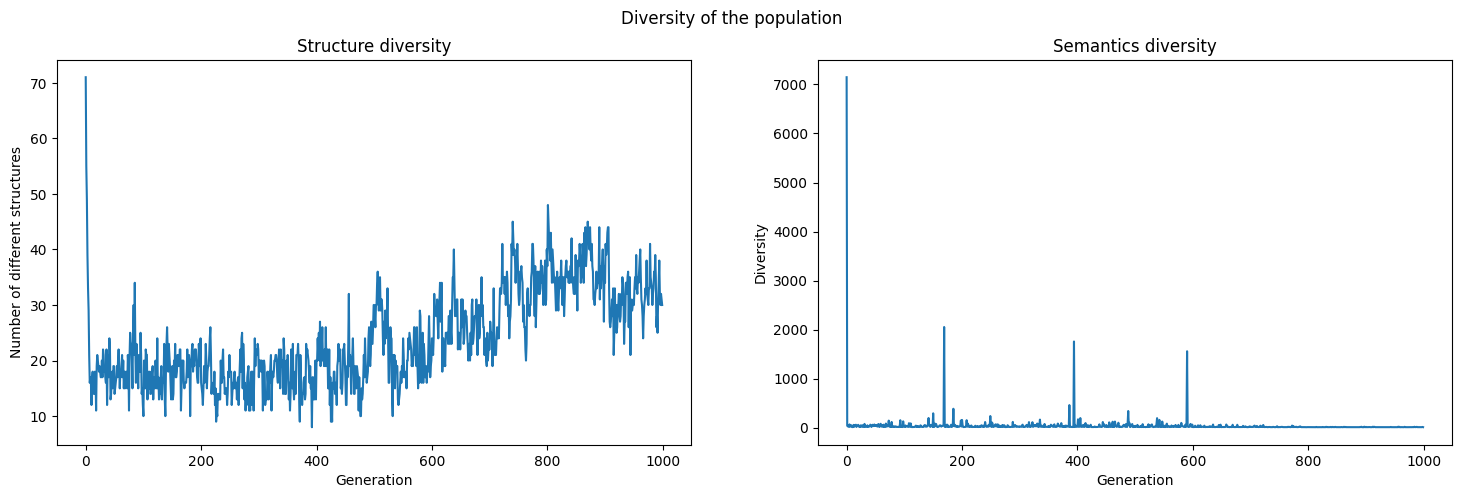

In [4]:
seed = 10

X,y = datasets[2]()  # AIRFOIL
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
X_train = torch.tensor(scaler_X.fit_transform(X_train))
y_train = torch.tensor(scaler_y.fit_transform(y_train.reshape(-1,1))).flatten()
X_test = torch.tensor(scaler_X.transform(X_test))
y_test = torch.tensor(scaler_y.transform(y_test.reshape(-1,1))).flatten()

agelog = LogAge()
divlog = LogDiversity()
early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train, test_elite=False,
                    dataset_name='test', slim_version='SLIM*ABS',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=1000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.45, p_struct=0.25, struct_mutation=True, 
                    prob_const=0.2, n_elites=1, selector='tournament', pressure_size=0.5,
                    decay_rate=0.2, p_xo=0, p_struct_xo=0,
                    callbacks=[agelog, divlog, early_stop],
                    depth_distribution='diz', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()

|       test      |       1000      |      0.116      |       None      |      0.061      |       164       |        7        |      7.960      |      13.010     |    0.73 (13)    |    0.55 (53)    |    0.06 (33)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
RMSE: tensor(0.1250, dtype=torch.float64)


|       test      |       1000      |      0.133      |       None      |      0.078      |       196       |        23       |      2.030      |      12.810     |    0.62 (10)    |    0.88 (42)    |    0.18 (47)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
RMSE: tensor(0.1464, dtype=torch.float64)


In [23]:
count = 0
for num in population.fit:
    count += num.item()

print('Average fitness:', count/len(population.fit))

Average fitness: 684.4216248960993


In [26]:
datasets[2]()[0].shape

torch.Size([1503, 5])

In [27]:
X.shape

torch.Size([100, 1])

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      1.216      |       None      |      0.022      |        3        |        0        |      2.000      |      2.000      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

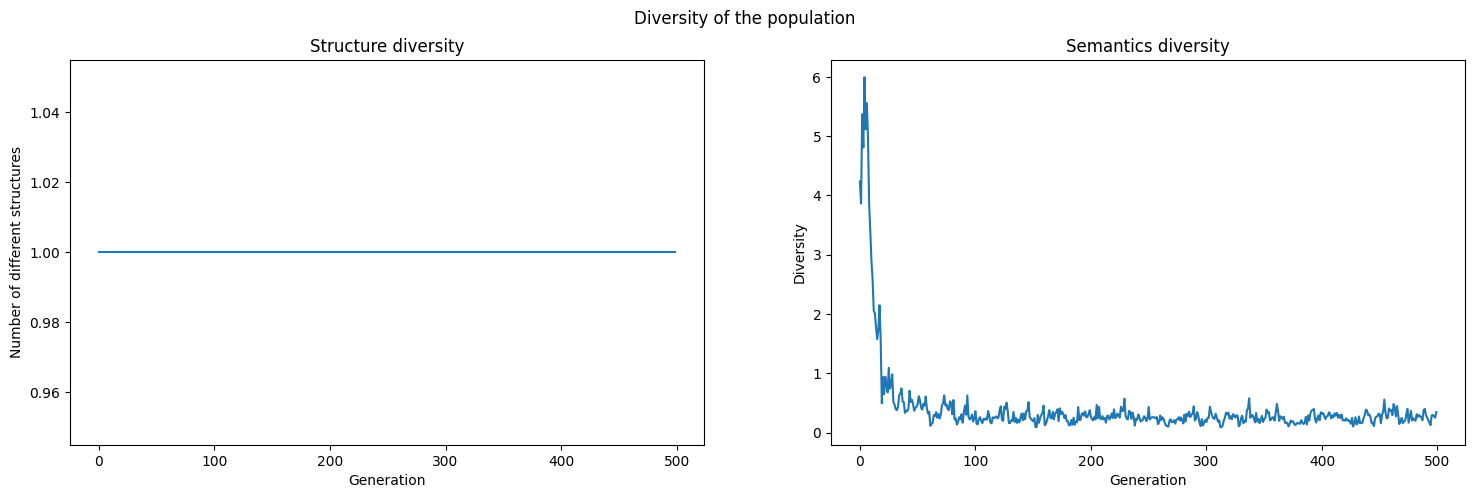

In [35]:
seed = 50
# Create a mock dataset
X = torch.randn(100, 1) + 2
y = -0.1 * X + torch.randn(100, 1) * 0.1
y = y.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, test_elite=False,
                    dataset_name='test', slim_version='SLIM*SIG1', initializer='simple',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=500, seed=seed, verbose=1,
                    p_inflate=0.5, prob_const=0.20, n_elites=1, selector='tournament',
                    decay_rate=0.12, p_xo=0, p_struct_xo=0, struct_mutation=False,
                    callbacks=[agelog, divlog], ms_lower=0, ms_upper=1,
                    depth_distribution='norm', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()

In [38]:
# Use the 10 best individuals to test the ensemble
best_individuals = sorted(population, key=lambda x: x.fitness)[:1]
ensemble_preds = []
for ind in best_individuals:
    ind.version = example_tree.version
    ensemble_preds.append(ind.predict(X_test))
ensemble_preds = np.array(ensemble_preds)
ensemble_preds = torch.tensor(np.mean(ensemble_preds, axis=0))
print('Ensemble RMSE:', rmse(ensemble_preds, y_test))

Ensemble RMSE: tensor(0.2360)


In [9]:
seen_semantics = {}
total_mutations = 0
for ind in population.population:
    semantics = ind.train_semantics[1:]
    for sem_ in semantics:
        total_mutations += 1
        sem = sem_[:2]
        sem = sem.tolist()
        sem = str(sem)
        if sem in seen_semantics:
            seen_semantics[sem] += 1
        else:
            seen_semantics[sem] = 1

seen_semantics = {k: v for k, v in sorted(seen_semantics.items(), key=lambda item: item[1], reverse=True)}
seen_semantics

{'[0.7230196215769629, 0.6002229638017295]': 14,
 '[0.24796877708827428, 0.2479687770882788]': 6,
 '[0.30017995673080594, 0.27233717394464]': 4,
 '[0.3187892641318919, 0.45899144458541086]': 4,
 '[0.0020311404438714963, 0.0008681491847771386]': 4,
 '[0.27158352572178357, 0.3533709826224462]': 2,
 '[1.84063092704671e-05, 2.169333863430165e-05]': 2,
 '[-0.07684937859118623, -0.13131736710802744]': 2,
 '[0.044274846711818534, 0.06370220906924576]': 2,
 '[0.0, 0.0]': 2,
 '[0.0004907770662783563, 0.0013050828354391956]': 2,
 '[0.20576008307512586, 0.09953229934861142]': 1,
 '[0.007425623029711139, 0.012889177956393251]': 1,
 '[0.010917039004823563, 0.01626504675423389]': 1,
 '[0.1088245171169006, 0.050542047254475066]': 1,
 '[-0.5512001167212511, -0.8423733538179834]': 1,
 '[0.975037526555191, 0.0]': 1,
 '[-0.0013744028073024487, -0.08114125153987757]': 1,
 '[0.20078269144766503, 0.20482835891112713]': 1,
 '[0.15695009627917758, 0.22653591229798553]': 1,
 '[-0.24889990972506074, -0.41043121

In [5]:
# Check how many individuals have the most common semantics
most_common_semantics = list(seen_semantics.keys())[0]
count = 0
count_ = 0
for ind in population.population:
    semantics = ind.train_semantics[1:]
    check = True
    for sem_ in semantics:
        sem = sem_[:2]
        sem = sem.tolist()
        sem = str(sem)
        if sem == most_common_semantics:
            count += 1
            break
count

4

In [6]:
population.population[0].structure

[('multiply',
  ('add',
   ('subtract',
    'constant__0.76',
    ('add', ('multiply', 'constant__0.18', 'constant__0.9'), 'constant_0.05')),
   ('multiply',
    ('add',
     ('divide', ('add', 'x2', 'x4'), ('divide', 'x4', ('divide', 'x3', 'x3'))),
     ('divide', ('add', 'x4', 'constant_0.83'), 'x1')),
    ('multiply', 'x0', 'x4'))),
  'constant__0.67')]

In [163]:
# Which ones dont have 
for ind in population.population:
    semantics = ind.train_semantics[1:]
    for sem_ in semantics:
        sem = sem_[:5]
        sem = sem.tolist()
        sem = str(sem)
        if sem != most_common_semantics:
            print(sem)
            break

[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[1.1213422461523217, 1.0826020837220371, 1.107485585333633, 1.1092573946161297, 1.0144084577210426]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.543607950

In [40]:
preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))
print('Nodes:', example_tree.nodes_count)

example_tree_ = simplify_individual(example_tree, y_val, X_val, threshold=0.05)
preds_ = example_tree_.predict(X_test)
print('RMSE:', rmse(preds_, y_test))
print('Nodes:', example_tree_.nodes_count)

RMSE: tensor(0.1206, dtype=torch.float64)
Nodes: 124
RMSE: tensor(0.1289, dtype=torch.float64)
Nodes: 17


In [41]:
example_tree_.structure

[(np.str_('divide'),
  ('subtract',
   ('multiply',
    ('add', 'constant_0.4', ('divide', 'x1', 'x2')),
    ('multiply', ('multiply', 'x4', 'x2'), ('divide', 'x0', 'x4'))),
   'constant_0.41'),
  'constant__0.61')]

In [49]:
# Try a NN with the same architecture
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(10, input_dim=5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=250)])
preds = model.predict(X_test)
print('RMSE:', rmse(torch.tensor(preds).flatten(), y_test))

ModuleNotFoundError: No module named 'tensorflow'

In [25]:
example_tree_.structure[0]
simplified = example_tree_

In [8]:
def get_indices_with_levels_mod(tree):
    """
    Get all indices that can be used to access valid subtrees or terminal nodes in a tree,
    along with their corresponding levels in the tree.

    Parameters
    ----------
    tree : tuple
        The root node of the tree.

    Returns
    -------
    list
        A list of tuples, each containing an index path and its corresponding level in the tree.
    """
    
    def traverse(sub_tree, path=(), level=0):
        indices_with_levels = []
        
        # If not tuple 
        if not isinstance(sub_tree, tuple):
            indices_with_levels.append((path, level))

        # If tuple, separate
        else:
            indices_with_levels.append((path, level)) if path != () else None
            op, left, right = sub_tree  
            # Can substitute the left or right
            indices_with_levels.extend(traverse(left, path + (1,), level + 1))
            indices_with_levels.extend(traverse(right, path + (2,), level + 1))

        return indices_with_levels
    
    return [((), (0))] + traverse(tree)

def structure_mutation(FUNCTIONS, TERMINALS, CONSTANTS, depth_dist="norm"):
    """
    Generate a function for the structure mutation.

    Parameters
    ----------
    FUNCTIONS : dict
        The dictionary of functions used in the mutation.
    TERMINALS : dict
        The dictionary of terminals used in the mutation.
    CONSTANTS : dict
        The dictionary of constants used in the mutation.
    depth_dist : str, optional
        Distribution to choose the depth of the new tree (default: "norm"), options: "norm", "exp", "uniform", "max", "diz"
        If diz is chosen, then we can only decrease/increase the depth by 1 or not change it at all.
    Returns
    -------
    
    Callable
        A structure mutation function (`structure`).
        
    """
    def structure(individual,
                        X,
                        max_depth=8,
                        p_c=0.1,
                        X_test=None,
                        grow_probability=1,
                        reconstruct=True, 
                        decay_rate=0.2,
                        **args,
    ):
        """
        Perform a mutation on a given Individual by changing the main structure of the tree.

        Parameters
        ----------
        individual : Individual
            The Individual to be mutated.
        X : torch.Tensor
            Input data for calculating semantics.
        max_depth : int, optional
            Maximum depth for generated trees (default: 8).
        p_c : float, optional
            Probability of choosing constants (default: 0.1).
        p_prune : float, optional
            Probability of pruning the tree (default: 0.5).
        X_test : torch.Tensor, optional
            Test data for calculating test semantics (default: None).
        grow_probability : float, optional
            Probability of growing trees during mutation (default: 1). 
            If changed, trees will be completely replaced during mutation more often.
        replace_probability : float, optional
            Probability of replacing the main tree during mutation (default: 0.1).
        X_test : torch.Tensor, optional
            Test data for calculating test semantics (default: None).
        exp_decay : bool, optional
            Flag to indicate whether exponential decay should be used to soften the mutation (default: False).
        reconstruct : bool
            Whether to store the Individuals structure after mutation.

        Returns
        -------
        Individual
            The mutated individual
        """

        indices_with_levels = get_indices_with_levels_mod(individual.structure[0])
        valid_indices_with_levels = [(index, level) for index, level in indices_with_levels if max_depth - len(index) >= 2]

        if not valid_indices_with_levels:
            raise ValueError("No valid indices satisfy the condition max_depth - len(index) >= 2")

        valid_indices, valid_levels = zip(*valid_indices_with_levels)

        if depth_dist == "diz": 
            # Can only choose either an index with max depth, or the one before
            individual_depth = individual.depth_collection[0]
            if random.random() < 0.5:
                chosen_level = individual_depth - 2
                depth = random.choice([1, 2, 3])
            else:
                chosen_level = individual_depth - 1
                depth = random.choice([1, 2])

            valid_indices = [index for index, level in valid_indices_with_levels if level == chosen_level]
            random_index = random.choice(valid_indices)

        else:
            probs = exp_decay_prob(max(valid_levels) + 1, decay_rate=decay_rate)
            level_probs = [probs[level] for level in valid_levels]
            random_index = random.choices(valid_indices, weights=level_probs)[0]

            if depth_dist == "norm":
                depth = choose_depth_norm(max_depth, random_index, mean=None, std_dev=None)
                
            else:
                depth = max_depth - len(random_index)   
                depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
                
                if depth_dist == "exp":
                    probs = exp_decay_prob(len(depths), decay_rate=decay_rate)
                    depth = random.choices(depths, weights=probs)[0]    
                    
                elif depth_dist == "uniform":
                    depth = random.choice(depths)
                    
                elif depth_dist == "max":
                    depth = depths[-1]
                            
        
        # If just a node is selected
        if depth == 1:
            if random.random() < p_c:
                new_block = random.choice(list(CONSTANTS.keys()))
            else:
                new_block = random.choice(list(TERMINALS.keys()))
            
            # Swap the subtree in the main tree
            new_structure = swap_sub_tree(individual.structure[0], new_block, list(random_index))
                        
        else:
            rt = get_random_tree(
            depth,
            FUNCTIONS,
            TERMINALS,
            CONSTANTS,
            inputs=X,
            p_c=p_c,
            grow_probability=grow_probability,
            logistic=False,
        )         

            # Swap the subtree in the main tree
            new_structure = swap_sub_tree(individual.structure[0], rt.structure, list(random_index))
    
        # Create the new block
        new_block = Tree(structure=new_structure,
                            train_semantics=None,
                            test_semantics=None,
                            reconstruct=True)
        
        new_block.calculate_semantics(X)            
        
        # Create the offspring individual
        if X_test is not None:
            new_block.calculate_semantics(X_test, testing=True, logistic=False)
            
        offs = Individual(
            collection=[new_block, *individual.collection[1:]],
            train_semantics=torch.stack(
                [
                    new_block.train_semantics,
                    *individual.train_semantics[1:],
                ]   
            ),
            test_semantics=(
                torch.stack(
                    [
                        new_block.test_semantics,
                        *individual.test_semantics[1:],
                    ]
                )
                if X_test is not None
                else None
            ),
            reconstruct=reconstruct
        )

        # computing offspring attributes
        offs.size = individual.size
        offs.nodes_collection = [new_block.nodes,*individual.nodes_collection[1:]]
        offs.nodes_count = sum(offs.nodes_collection) + offs.size - 1

        offs.depth_collection = [new_block.depth, *individual.depth_collection[1:]]
        offs.depth = max(offs.depth_collection) + offs.size - 1
        offs.version = individual.version

        offs.id = individual.id

        return offs    
    
    return structure

In [12]:
simplified.depth_collection[0]

3

In [11]:
struct_mut = structure_mutation(FUNCTIONS=simplified.collection[1].FUNCTIONS, 
                                CONSTANTS=simplified.collection[1].CONSTANTS,
                                TERMINALS=simplified.collection[1].TERMINALS,
                                depth_dist='exp')

rmse_vals = []
size_vals = []
current_best_score = 0.5
current_best = None

for i in range(5000):
    simplified_mut = struct_mut(simplified, X=X_train, max_depth=7, decay_rate=2)
    # simplified_mut = simplify_individual(simplified_mut, y_val, X_val, threshold=0.01)
    simplified_mut.version = simplified.version
    preds_ = simplified_mut.predict(X_test)
    rmse_ = rmse(preds_, y_test)
    if rmse_ < current_best_score:
        current_best_score = rmse_
        current_best = simplified_mut
        print('New best:', rmse_)
        print(simplified_mut.structure[0])
    rmse_vals.append(rmse_)
    size_vals.append(simplified_mut.nodes_collection[0])

New best: tensor(0.4806, dtype=torch.float64)
('multiply', ('add', 'x2', 'x3'), 'constant_0.37')
New best: tensor(0.4568, dtype=torch.float64)
('multiply', ('add', 'x1', ('subtract', 'x1', ('multiply', ('subtract', 'x1', 'x1'), 'x3'))), 'constant_0.37')
New best: tensor(0.3165, dtype=torch.float64)
('multiply', ('add', 'x2', 'x1'), 'constant_0.37')
New best: tensor(0.2693, dtype=torch.float64)
('multiply', ('divide', 'x2', 'x2'), 'constant_0.37')
New best: tensor(0.2232, dtype=torch.float64)
('multiply', ('subtract', 'constant_0.75', 'x4'), 'constant_0.37')
New best: tensor(0.1469, dtype=torch.float64)
('multiply', 'constant_0.7', ('divide', 'constant_0.32', ('divide', 'x0', 'x0')))
New best: tensor(0.1327, dtype=torch.float64)
('multiply', ('divide', 'constant_0.77', 'constant_0.97'), 'constant_0.37')


In [17]:
preds = current_best.predict(X_test)
print('RMSE:', rmse(preds, y_test))
print('Nodes:', current_best.nodes_count)

current_best_ = simplify_individual(current_best, y_train, X_train, threshold=0.01)
preds_ = current_best_.predict(X_test)
print('RMSE:', rmse(preds_, y_test))
print('Nodes:', current_best_.nodes_count)

RMSE: tensor(0.1280, dtype=torch.float64)
Nodes: 124
RMSE: tensor(0.1280, dtype=torch.float64)
Nodes: 124


RMSE: tensor(0.1158, dtype=torch.float64) </br>
('multiply', 'constant_0.7', ('add', 'x1', 'constant__0.26'))

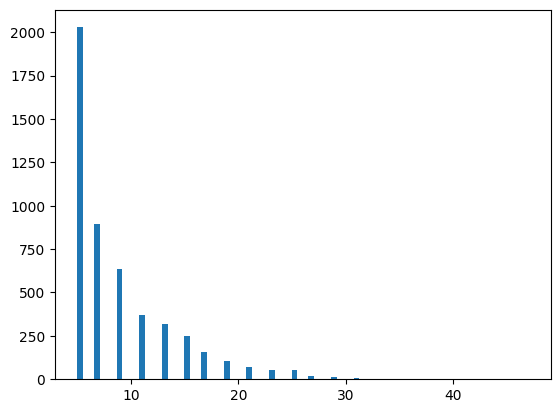

In [113]:
# Plot the distribution of the size of the trees
plt.hist(size_vals, bins=80)
plt.show()

In [114]:
np.min(size_vals)

np.int64(5)

In [80]:
rmse_vals = np.array(rmse_vals)
print('Mean RMSE:', np.min(rmse_vals))
best_id = np.argmin(rmse_vals)
print('Best ID:', best_id)

Mean RMSE: 0.12632628496653595
Best ID: 929


In [40]:
seed = 0

X,y = datasets[13]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, # X_test=X_test, y_test=y_test,
                    dataset_name='test', test_elite=False, slim_version='SLIM*SIG1',
                    max_depth=12, init_depth=4, pop_size=20, n_iter=2000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.4, p_struct=0.2, # selector='e_lexicase',
                    struct_mutation=True, decay_rate=0.1, p_xo=0, type_structure_mutation='new', callbacks=[agelog, divlog],
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.409      |       None      |      0.006      |        3        |       258       |      2.950      |      2.950      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

best 0.243070

In [2]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

In [ ]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

# Example usage
max_depth = 22
random_index = [1, 2,2,2,2,2]  # Example index

depths = []
for i in range(10000):
    depths.append(choose_depth(max_depth, random_index))
    
plt.hist(depths, bins=np.arange(1, max_depth + 1) - 0.5, rwidth=0.8)
plt.show()

In [2]:
seed = 0

X,y = datasets[10]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, # X_test=X_test, y_test=y_test,
                    dataset_name='test', test_elite=False, slim_version='SLIM*SIG1',
                    max_depth=22, init_depth=10, pop_size=100, n_iter=100, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.4, p_struct=0.2, selector='e_lexicase',
                    struct_mutation=False, decay_rate=0.1, p_xo=0, type_structure_mutation='new', callbacks=[agelog, divlog],
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.234      |       None      |      0.213      |        3        |    2128770183   |      4.910      |      4.910      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

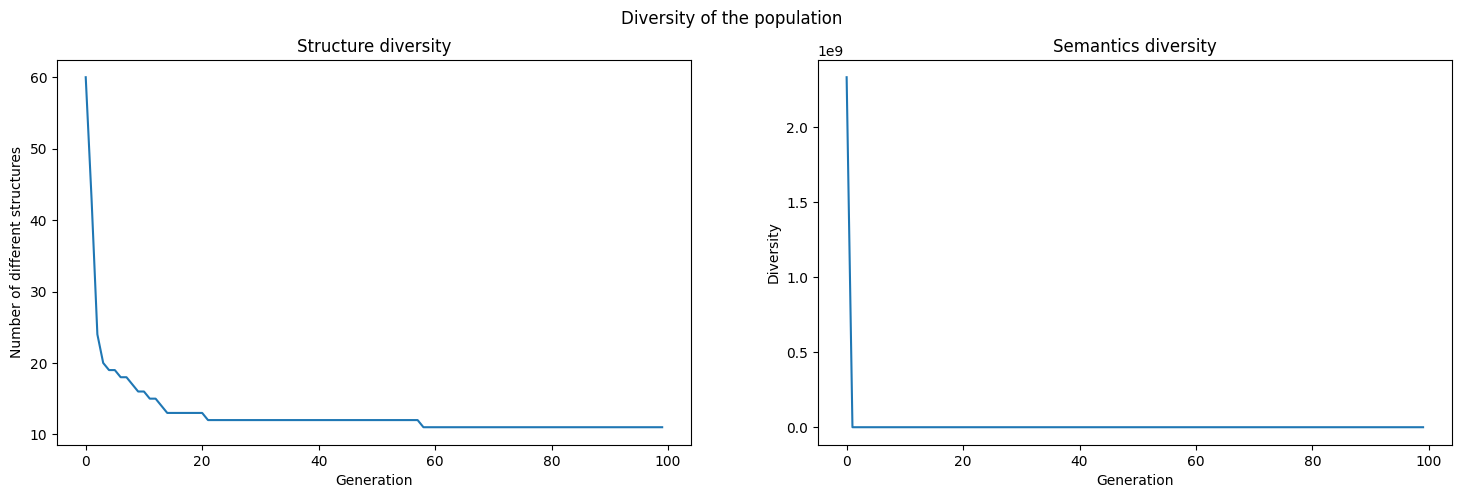

In [3]:
divlog.plot_diversity()

In [94]:
# Check the fitness for each individual
fitnesses = []

for tree in population.population:
    preds = tree.predict(X_test)
    fitnesses.append(rmse(preds, y_test))

# Get the 10 best fitnesses from the fitnesses list 
best_fitnesses = sorted(fitnesses)[:10]

# Get the ids 
best_ids = [fitnesses.index(i) for i in best_fitnesses]

ten_best = [population.population[i] for i in best_ids]

# Create a dataset and predict a linear model for the stacking ensemble
X_train_stacking = torch.zeros((X_train.shape[0], size))
X_test_stacking = torch.zeros((X_test.shape[0], size))

for i, tree in enumerate(ten_best):
    tree.version = 'SLIM*SIG1'
    X_train_stacking[:, i] = tree.predict(X_train)
    X_test_stacking[:, i] = tree.predict(X_test)
    
# Train a linear model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_stacking, y_train)

preds = lr.predict(X_test_stacking)
print('RMSE:', rmse(torch.tensor(preds), y_test))

RMSE: tensor(0.1013, dtype=torch.float64)


In [ ]:
constants = example_tree.collection[0].CONSTANTS
functions = example_tree.collection[0].FUNCTIONS
terminals = example_tree.collection[0].TERMINALS
depths = []

for i in range(10000):
    dep = choose_depth(14, [1,1,1,1])
    # dep = random.choice(np.arange(1, 14 + 1))
    # probs = exp_decay_prob(14, 0.3)
    # dep = random.choices(np.arange(1, 14 + 1), weights=probs, k=1)[0]
    if dep == 1:
        depths.append(1)
    else:
        depth = get_random_tree(max_depth=dep, 
                        FUNCTIONS=functions,
                        TERMINALS=terminals,
                        CONSTANTS=constants,
                        p_c=0.1).depth
        
        depths.append(depth)

plt.hist(depths, bins=np.arange(1, 14 + 1) - 0.5, rwidth=0.8)
plt.show()

In [15]:
indices_with_levels = get_indices_with_levels(example_tree.structure[0])
valid_indices_with_levels = [(index, level) for index, level in indices_with_levels if 22 - len(index) >= 2]


valid_indices, valid_levels = zip(*valid_indices_with_levels)
probs = exp_decay_prob(max(valid_levels) + 1, decay_rate=0.2)
level_probs = [probs[level] for level in valid_levels]
random_index = random.choices(valid_indices, weights=level_probs)[0]

In [4]:
indices_list = get_indices_with_levels(example_tree.structure[0])

In [ ]:
get_indices_with_levels(example_tree.structure[0])

In [ ]:
exp_decay_prob(5, decay_rate=0.3)

In [ ]:
decay_prob

In [17]:
counts_dict = {}

for i in range(10000):
    random_index = random.choices(indices_list, weights=decay_prob)[0]
    if random_index in counts_dict:
        counts_dict[random_index] += 1
    else:
        counts_dict[random_index] = 1

In [ ]:
counts_dict